# Land/Soil Level "Food Safety" & Community Food Production

**By Melody Ng**

The notebooks for this project represent preliminary research for a larger project that aims to to explore how narratives around “food safety” have shaped local land use (and potentially environmental) policies that have consequently impacted land use for food production in communities. In the U.S. there is a history of land use regulations being used to move/keep the urban poor and racial and ethnic minorities out of cities (as a larger project to maximize land values) (Brinkley & Vitiello 2014, Vitiello & Brinkley 2014). While housing policy is one of the (most prominent) means through which segregation and exclusion was facilitated, food safety regulations via local codes to discourage food production in urban settings were also part of this process. In recent years municipalities have attempted to modify land use codes to make it easier for residents to engage in community food production/urban agriculture. However, in addition to the limitations of these new well-intended policies, many community growers remain limited by food safety policies that among other things prevent them from fully participating in local food economies (e.g. selling what they grow on site). At the same time, growers themselves -- particularly those in marginalized majority BIPOC communities -- have expressed their own safety concerns around growing food within their communities given that some of/the only lands available to them for food production, due to past and present nearby industrial/intensive agricultural uses, have contaminated local soils. 

This project aims to use some basic natural language processing techniques to better understand how cities are (or are not) accommodating community food production needs in their General Plans -- the long-range planning document that governs city decisionmaking about how land will be used -- in up to five California Counties -- Los Angeles, Ventura, Sonoma, Mendocino, and Lake. 

The larger project -- that this project is a part of -- aims to examine the presence or absence of “food safety” concerns at two different junctions in the community food supply chain: (A) food production at the community level via health of the land and soil (community-articulated food safety concerns) and (B) public health regulations for processing and retailing (state-articulated food safety concern). To begin to explore (A), this project examines the General Plans for Los Angeles, Ventura, Sonoma, Mendocino, and Lake Counties to better understand the extent to which these major land use plans consider local food production and/or local land and soil health more generally. Eventually, this project may extend to natural language processing of other policy documents at different jurisdictional levels (California Code of Regulations (CCR), state level legislation, city codes of ordinances, etc.).

While the scope for this larger project includes all five Counties -- Los Angeles, Ventura, Sonoma, Mendocino, and Lake -- and the General Plans that were collected and some of the data produced in this notebook include all five Counties, most of the analysis focuses on Los Angeles County. The hope is that the analysis for LA County can be replicated, extended, and improved upon for the other four counties in future research.

**REFERENCES**

  *1. Brinkley, C., & Vitiello, D. (2014). From farm to nuisance: Animal agriculture and the rise of planning regulation. Journal of planning history, 13(2), 113-135.*

  *2. Vitiello, D., & Brinkley, C. (2014). The hidden history of food system planning. Journal of Planning History, 13(2), 91-112.*

## Overview of Data & Analysis 

This project utilizes the following data sources:

    1. City General Plans
    2. Toxic Release data for California
    4. Urban agriculture site data for Los Angeles County

For more information about the data sources, please see the "LAC Map" notebook.

The following exercises are detailed in this notebook:

    1. Basic keyword counts in plans
    2. Proximity of keywords to each other in plans
    3. Modified topic modeling focusing on sections of plans that mention keywords related to community food production

In [73]:
# libraries: basic data processing and mapping
import pandas as pd
import geopandas as gpd
import numpy as np

# visualizations
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sn

# set display
pd.options.display.max_columns = 150
pd.options.display.max_rows = 300

In [127]:
# libraries: natural language processing
import os

# extract text
from pdfminer.high_level import extract_text
import re

# stop words; split sentences; stems
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

# topic modeling
import gensim
import pyLDAvis
import pyLDAvis.gensim_models

#### The Plans & Plan Elements

General Plans are the long-range planning document that guides city-planning decisions in municipalities. California requires these plans to include some basic "elements", including but not limited to land use, circulation, housing, open space, recreation, and conservation. Every effort was made to include the most recently adopted, full versions of the General Plan for each city. However, despite the key role they play in long-range city-planning, General Plans are not generally stored in any kind of publicly accessible directory, and therefore they must be located and downloaded individually for each city. Moreover, there is no standard format that cities have chosen to make their General Plans available to the public. Almost all are saved as PDFs, and only some are available as a single organized document. Half as often, the plans were stored as separate elements, with some cities providing no "table of contents" to inform readers about the intended organization of the separate plan elements. In those cases, by default, I organized these plan elements based on a common format that was noticeable in most plans: land use, housing, economic development, open space, recreation, conservation, safety, and noise. A fifth of them were scanned documents that had to be converted into searchable PDFs.

Getting the PDFs into one file containing all the General Plans involved two steps. Most whole documents were downloaded directly into the Github repository. However, both individual plan elements and some of the whole plans that were too large in size to download directly to the repository -- due to upload size maximums -- and had to be split and uploaded into a separate plan sections subfolder and subsequently remerged using Python (see "Prepping Plans" notebook).

While 112 total municipalities across LA, Ventura, Sonoma, Mendocino, Lake Counties were originally identified for inclusion in this project, due to both the lack of availability of some of the plans (which are not always easily and publicly accessible) and technical difficulties parsing some of the plans. Los Angeles City was excluded (despite its large land area and large population), because in lieu of a single Land Use Element in its General Plan, it has 35 different Community Land Use Plans that each cover an assortment of contiguous neighborhoods within the City. Without more time to understand how the boundaries for these 35 communities were formed or whether they correspond to/align neatly with any formal jurisdictional lines (e.g. neighborhoods, districts, etc.), I was reluctant to include them in this preliminary analysis.

Gardena, Glendora, Pomona, and Walnut were excluded from this analysis because their General Plans were not readable/would not upload properly despite multiple attempts to parse them. Lakewood was also excluded, since after repeated searches on their city's website and inquiries to the city about the document, access to the plan document could not be obtained.

Consequently, 106 plans were ultimately included in the analysis.

*NOTE: The plans were parsed in two batches to avoid spontaneous kernel shutdowns/restarts with the resulting list of lists joined together after.*

In [366]:
# loading plans
planlistA = os.listdir('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans A')
planlistA

['.ipynb_checkpoints',
 'Agoura Hills.pdf',
 'Alhambra.pdf',
 'Arcadia.pdf',
 'Artesia.pdf',
 'Avalon.pdf',
 'Azusa.pdf',
 'Baldwin Park.pdf',
 'Bell Gardens.pdf',
 'Bell.pdf',
 'Bellflower.pdf',
 'Beverly Hills.pdf',
 'Bradbury.pdf',
 'Burbank.pdf',
 'Calabasas.pdf',
 'Camarillo.pdf',
 'Carson.pdf',
 'Cerritos.pdf',
 'Claremont.pdf',
 'Clearlake.pdf',
 'Commerce.PDF',
 'Compton.pdf',
 'Cotati.pdf',
 'Covina.pdf',
 'Cudahy.pdf',
 'Culver City.pdf',
 'Diamond Bar.pdf',
 'Downey.pdf',
 'Duarte.pdf',
 'El Monte.pdf',
 'El Segundo.pdf',
 'Filmore.pdf',
 'Fort Bragg.pdf',
 'Glendale.pdf',
 'Hawaiian Gardens.pdf',
 'Hawthorne.pdf',
 'Healdsburg.pdf',
 'Hermosa Beach.pdf',
 'Hidden Hills.pdf',
 'Huntington Park.pdf',
 'Industry.pdf',
 'Inglewood.pdf',
 'Irwindale.pdf',
 'La Canada Flintridge.pdf',
 'La Habra Heights.pdf',
 'La Mirada.pdf',
 'La Puente.pdf',
 'La Verne.pdf',
 'Lakeport.pdf',
 'Lancaster.pdf',
 'Lawndale.pdf',
 'Lomita.pdf',
 'Long Beach.pdf',
 'Lynwood.pdf',
 'Malibu.pdf',
 'M

In [4]:
# loading plans
planlistB = os.listdir('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans B')
planlistB

['.ipynb_checkpoints',
 'Point Arena.pdf',
 'Port Hueneme.pdf',
 'Rancho Palos Verdes.pdf',
 'Redondo Beach.pdf',
 'Rohnert Park.pdf',
 'Rolling Hills Estates.pdf',
 'Rolling Hills.pdf',
 'Rosemead.pdf',
 'San Dimas.pdf',
 'San Fernando.pdf',
 'San Gabriel.pdf',
 'San Marino.pdf',
 'Santa Clarita.pdf',
 'Santa Fe Springs.pdf',
 'Santa Monica.pdf',
 'Santa Paula.pdf',
 'Santa Rosa.pdf',
 'Sebastopol.pdf',
 'Sierra Madre.pdf',
 'Signal Hill.pdf',
 'Simi Valley.pdf',
 'Sonoma.pdf',
 'South El Monte.pdf',
 'South Gate.pdf',
 'South Pasadena.pdf',
 'Temple City.pdf',
 'Thousand Oaks.pdf',
 'Torrance.pdf',
 'Ukiah.pdf',
 'Ventura.pdf',
 'Vernon.pdf',
 'West Covina.pdf',
 'West Hollywood.pdf',
 'Westlake Village.pdf',
 'Whittier.pdf',
 'Willits.pdf',
 'Windsor.pdf']

In [365]:
# function: extracting text froms plans in folder A
def readPDF(planname):
    txt = extract_text('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans A/'+planname)
    
    # remove punctuation, numbers, etc.
    txt = re.sub(r"[^A-z\s]", "", txt)
    # remove whitepace
    txt = re.sub(r"\s+", " ", txt) 
    
    # cleaning up name
    planname = planname.split(".")[0]
    
    # insert muni(planname) to the beginning of plan: creating indexable muni ID within each plan string
    txt = planname+", "+txt
    
    print('Finished {}'.format(planname))
    return txt

# read in all pdf files
suffixes = ('.pdf', '.PDF')
genplanA = [readPDF(pn) for pn in planlistA if pn.endswith(suffixes)]

Finished Agoura Hills
Finished Alhambra
Finished Arcadia
Finished Artesia
Finished Avalon
Finished Azusa
Finished Baldwin Park
Finished Bell Gardens
Finished Bell
Finished Bellflower
Finished Beverly Hills
Finished Bradbury
Finished Burbank
Finished Calabasas
Finished Camarillo
Finished Carson
Finished Cerritos
Finished Claremont
Finished Clearlake
Finished Commerce
Finished Compton
Finished Cotati
Finished Covina
Finished Cudahy
Finished Culver City
Finished Diamond Bar
Finished Downey
Finished Duarte
Finished El Monte
Finished El Segundo
Finished Filmore
Finished Fort Bragg
Finished Glendale


TypeError: 'PSKeyword' object cannot be interpreted as an integer

In [5]:
# function: extracting text froms plans in folder B
def readPDF(planname):
    txt = extract_text('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans B/'+planname)
    
    # remove punctuation, numbers, etc.
    txt = re.sub(r"[^A-z\s]", "", txt)
    # remove whitepace
    txt = re.sub(r"\s+", " ", txt) 
    
    # cleaning up name
    planname = planname.split(".")[0]
    
    # insert muni(planname) to the beginning of plan: creating indexable muni ID within each plan string
    txt = planname+", "+txt
    
    print('Finished {}'.format(planname))
    return txt

# read in all pdf files
suffixes = ('.pdf', '.PDF')
genplanB = [readPDF(pn) for pn in planlistB if pn.endswith(suffixes)]

Finished Point Arena
Finished Port Hueneme
Finished Rancho Palos Verdes
Finished Redondo Beach
Finished Rohnert Park
Finished Rolling Hills Estates
Finished Rolling Hills
Finished Rosemead
Finished San Dimas
Finished San Fernando
Finished San Gabriel
Finished San Marino
Finished Santa Clarita
Finished Santa Fe Springs
Finished Santa Monica
Finished Santa Paula
Finished Santa Rosa
Finished Sebastopol
Finished Sierra Madre
Finished Signal Hill
Finished Simi Valley
Finished Sonoma
Finished South El Monte
Finished South Gate
Finished South Pasadena
Finished Temple City
Finished Thousand Oaks
Finished Torrance
Finished Ukiah
Finished Ventura
Finished Vernon
Finished West Covina
Finished West Hollywood
Finished Westlake Village
Finished Whittier
Finished Willits
Finished Windsor


In [7]:
# appending plan strings list parsed from plans in folder A to the parsed plans in folder B
genplan = genplanA + genplanB

In [217]:
# checking integrity of join and confirming plan totals
print(len(genplanA))
print(len(genplanB))
print(len(genplan))

69
37
106


In [9]:
# save list of plans to hardrive so that it called be reloaded/called directly instead of
#  having to rerun time and resource intensive scraping function
import pickle

with open('genplan.pickle', 'wb') as f:
    pickle.dump(genplan, f)

In [14]:
# establish list of stopwords to exclude
swords = stopwords.words('english')

### (A) Keyword Counts: Are Cities Even Talking About Food Systems?

This exercise aims to identify basic mentions of a select set of keywords related to community food production and the environment more generally by locating all unique positions for each keyword mentioned in the raw plan text. A version of this exercise was also attempted using a cleaned wordlist for each plan to compare which approach led to more or less mentions being identified in the plans. 

After comparing the two methods, it appears that more and fewer mentions of keywords varied between plans and keywords, so the accuracy of one method over the other remains unclear.

In [18]:
# saving positions of keywords in cleaned wordlists to a dictionary: all plans

# create empty dictionary to store topic mention counts
keydict1 = {}
# create empty list to store keyword count columns for each city
plan_col = []

keywords = ['food', 'agriculture', 'garden', 'farm', 'fruit', 'vegetable', 'animal', 'soil', 
            'remediation', 'contaminate', 'sustainability', 'climate', 'environment', 
            'health', 'safety', 'justice']

for plan in genplan:
    
    # generating wordlist from plan
    wordlist = [word for word in word_tokenize(plan.lower()) 
                 if word not in swords]
    
    # generate counts
    for key in keywords:
        # identify count of each mention of keyword and save to a dictionary
        keydict1[key] = wordlist.count(key) 

    # turn dicts into dfs
    keywordsc = pd.DataFrame.from_dict(keydict1, orient='index', columns=[plan.split(", ")[0]]) # muni plan name as series name
    
    # add each municipality column generated to a single dataframe
    plan_col.append(keywordsc)
    munikeys1 = pd.concat(plan_col, axis = 1)

# inspect/show
munikeys1

Agoura Hills  Alhambra  Arcadia  Artesia  Avalon  Azusa  \
food                       2        10       16       13      14      9   
agriculture                0         1        2        6       4      5   
garden                     0         9       15        1       9      2   
farm                       2         1       10        7       2      0   
fruit                      0         0        0        0       0      0   
vegetable                  0         1        0        0       0      0   
animal                     4         1        1        3       9      1   
soil                      17        16        8       10      18      5   
remediation                1         1        0        0       1      0   
contaminate                1         0        0        1       0      0   
sustainability            11         2       73       62       2      1   
climate                   49        43        9       51      17      6   
environment               36        33       54       40      39    251   
health                    28        85       82       70      55     35   
safety                    83        62      136       69      77     45   
justice                    1        22        0        0       0      0   

                Baldwin Park  Bell Gardens  Bell  Bellflower  Beverly Hills  \
food                      63            10     6          17             38   
agriculture               16             5     4          10              4   
garden                    26             1     6           4              9   
farm                       5             4     9          10              6   
fruit                      5             0     0           0              2   
vegetable                  0             0     0           0              0   
animal                     1             3     3          11              6   
soil                      12            14    11          11             37   
remediation                0             5     2           3              2   
contaminate                0             0     0           0              0   
sustainability            77             2   131           0             66   
climate                   26             6     6          75            179   
environment               63            27    28          36             67   
health                   196            67   162          69            181   
safety                   105           112   166         208            242   
justice                    0             7     7           4             21   

                Bradbury  Burbank  Calabasas  Camarillo  Carson  Cerritos  \
food                   6        9          7         20      40         4   
agriculture           20        7          2         81      11         6   
garden                 2        1          0          4       4         2   
farm                   9        2          0        130       7        12   
fruit                  1        0          0         20       0         0   
vegetable              0        0          0         11       0         0   
animal                17        6          7         13      17         7   
soil                  49        8         18         48      40         9   
remediation            0        1          0         23      20         1   
contaminate            1        1          1          2       0         0   
sustainability         7       27          6          1      12         5   
climate              219       72          5         21      57         9   
environment           75       44         81        117      92        99   
health               172       86         59        128     201        70   
safety               404      114        100        233     102       137   
justice                0        8          0          1      40         0   

                Claremont  Clearlake  Commerce  Compton  Cotati  Covina  \
food       

In [23]:
# reorienting table the keyword counts so they can be joined to other gdfs
munikeyst1 = munikeys1.transpose()

# naming index column
munikeyst1.index.name = "City"

# saving keyword counts table
munikeyst1.to_csv("Plan_Keyword_Counts_list.csv")

In [19]:
# saving positions of keywords in raw plan text to a dictionary: all plans
textdictall = {}
plan_cols = []

keywords = ['food', 'agriculture', 'garden', 'farm', 'fruit', 'vegetable', 'animal', 'soil', 
            'remediation', 'contaminate', 'sustainability', 'climate', 'environment', 
            'health', 'safety', 'justice']

for plan in genplan:
    for key in keywords:
        # identify text positions of keyword mentions
        textpositionsall = [i for i in range(len(plan)) if plan.startswith(key, i)] # adapted: https://www.geeksforgeeks.org/python-all-occurrences-of-substring-in-string/#
        # save list of positions for each keyword in a dictionary
        textdictall[key] = textpositionsall

    textdict = {}

    # generate counts for each keyword by summing the number of positions in its position list
    for keyword in textdictall:
        for position in keyword:
            # store counts in dictionary
            textdict[keyword] = len(textdictall[keyword])

        # turn dicts into dfs
        keywordscount = pd.DataFrame.from_dict(textdict, orient='index', columns=[plan.split(", ")[0]]) # muni plan name as series name
    
    # add each municipality column generated to a single dataframe
    plan_cols.append(keywordscount)
    munikeys = pd.concat(plan_cols, axis = 1)

# inspect/show
munikeys

Agoura Hills  Alhambra  Arcadia  Artesia  Avalon  Azusa  \
food                       2        12       15       15      11      8   
agriculture                0         1        0        3       1      4   
garden                     0        13        5        5       7      3   
farm                       2         1       14       12       1      5   
fruit                      0         1        0        2       0      1   
vegetable                  0         3        0        2       0      0   
animal                     8         1        1        4      10     12   
soil                      17        18       15       12      28     13   
remediation                1         0        0        0       1      0   
contaminate                2         0        0        1       0      1   
sustainability             9         1       14       23       2      1   
climate                   28        39        9       22      16      6   
environment               86        73      118       67      96     64   
health                    33        60      109       75      49     38   
safety                    51        32       67       39      34     37   
justice                    0        11        0        0       0      0   

                Baldwin Park  Bell Gardens  Bell  Bellflower  Beverly Hills  \
food                      81             7     5          16             28   
agriculture               10             4     1           5              3   
garden                    49            11     6           4             16   
farm                      31            26     7          23              9   
fruit                     10             0     0           0              2   
vegetable                  5             1     0           0              0   
animal                     2             5     2          13              4   
soil                      17            26    46          17             52   
remediation                0             5     1           3              2   
contaminate                9             1     0           0              3   
sustainability            27             1     8           0             37   
climate                   18             5     2          35            111   
environment              119            68    58          71            153   
health                   254            58    57          47            142   
safety                    55            50    56          57            116   
justice                    0             3     6           1              8   

                Bradbury  Burbank  Calabasas  Camarillo  Carson  Cerritos  \
food                   7        7          7         12      39         1   
agriculture           14        6          1         54       7         4   
garden                 2        4          1         13      17         6   
farm                  23        5          1        220      17        13   
fruit                  4        0          0         24       1         0   
vegetable              0        0          0         14       1         0   
animal                27        6          9          9      21         5   
soil                 100       16         35         77      56        14   
remediation            0        1          0          8      17         1   
contaminate            1        1          1          9       6         1   
sustainability         7       13          6          1      11         3   
climate               71       35          6         13      35         8   
environment          185      100        225        177     185       153   
health                53       85         56         82     153        55   
safety                68       51         48         75      55        61   
justice                0        5          0          0      12         0   

                Claremont  Clearlake  Commerce  Compton  Cotati  Covina  \
food       

In [32]:
# reorienting table the keyword counts so they can be joined to other gdfs
munikeyst = munikeys.transpose()

# naming index column
munikeyst.index.name = "City"

# saving keyword counts table
munikeyst.to_csv("Plan_Keyword_Counts_text.csv")

#### Visualizing Keyword Mentions

To get a better sense of which cities potentially include/exclude community food production in their long-range land use planning  goals and strategies, it would be ideal to map the distribution of keyword frequencies in the general plans to see how these frequencies might be distributed across cities in LA County. 

To produce a geodataframe that would allow for this, the keyword count table will be merged with a table that includes LA County city boundaries and preliminary information about the density of urban agriculture sites and facilities that produce toxic waste in a given city (created in the "LAC Map" notebook).

In [36]:
# joining keyword counts table to table with geocoded municipalities with preliminary UA site and Toxic Release densities

# loading file
LAC = gpd.read_file('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/LACfinal.geojson')

# set index to 'city' column
LAC.set_index('City', inplace = True)

# joining
LACmunikeys = munikeyst.join(LAC, how= 'left')

# converting to gdf 
LACmunikeys = gpd.GeoDataFrame(LACmunikeys, geometry = "geometry", crs='EPSG:4326')

The following set of choropleth maps show which cities in LA County mention a subset of keywords related to community food production. 

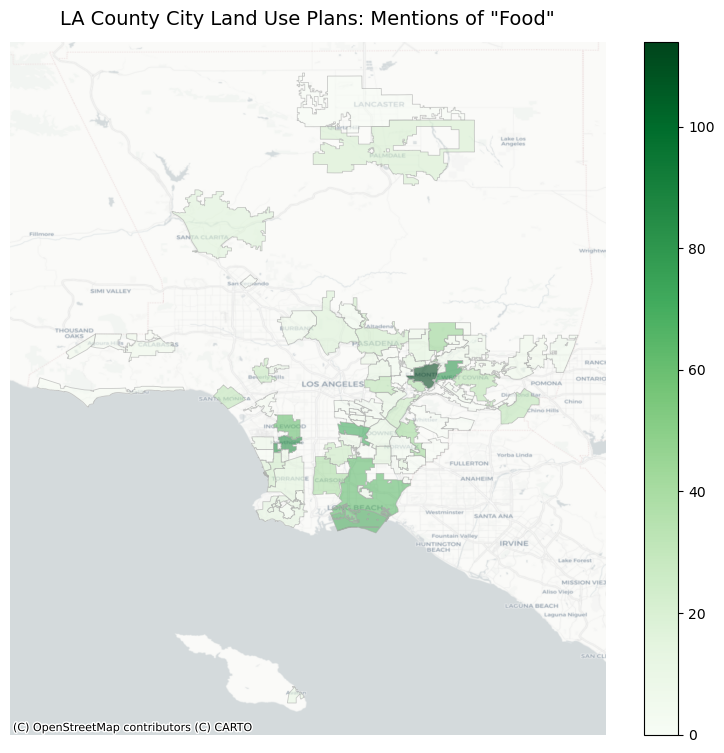

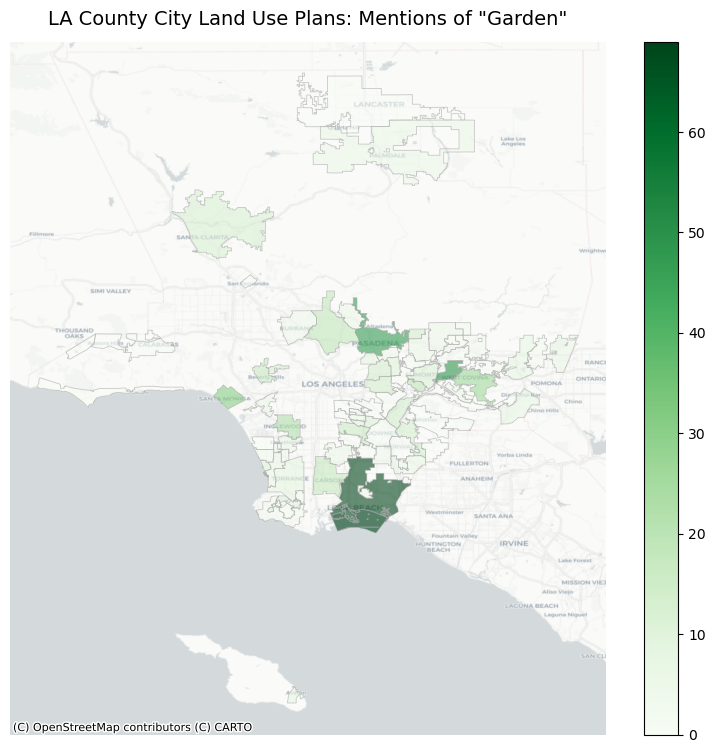

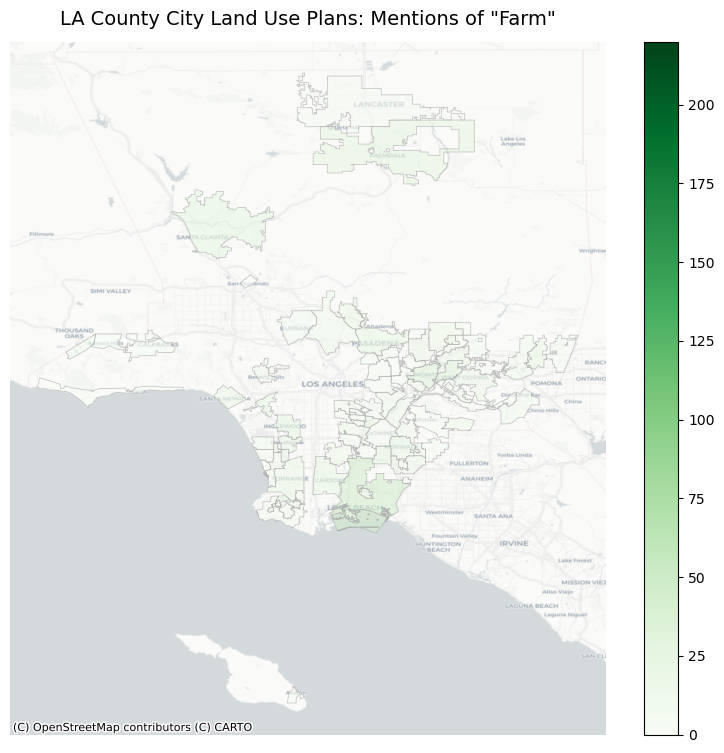

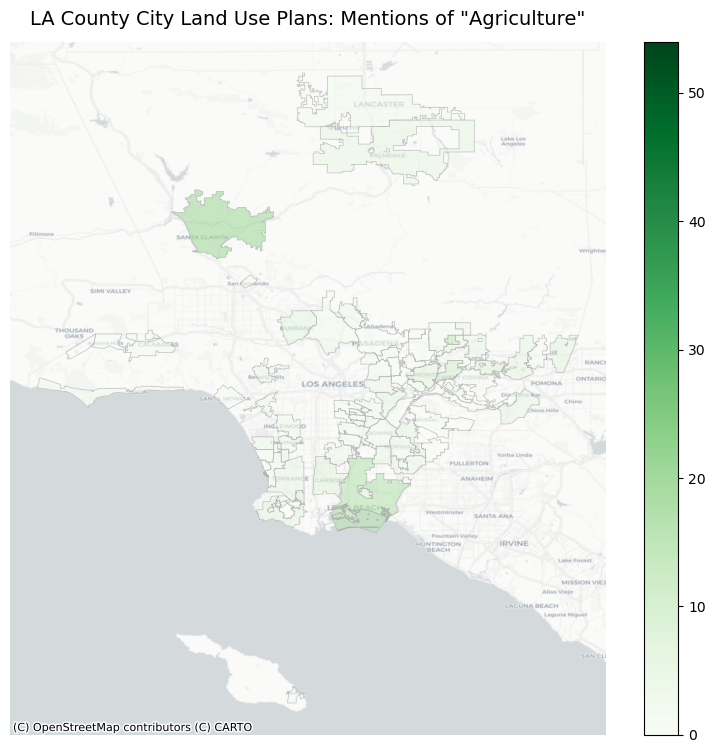

In [373]:
# loop to generate maps for each keyword

keywords = ['food', 'garden', 'farm', 'agriculture']

for key in keywords:
    fig, ax = plt.subplots(figsize =(10,9))
    
    # keyword
    LACmunikeys.plot(ax=ax,
                     column = key,
                     edgecolor = 'darkgrey',
                     linewidth = .6,
                     cmap = 'Greens',
                     alpha = .6,
                     legend = True)
    
    # customizations
    ax.axis('off')
    ax.set_title('LA County City Land Use Plans: Mentions of "{}"'.format(key.title()), 
                 fontsize=14, pad=12)
    
    # basemap
    ctx.add_basemap(ax, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)

The following sets of scatterplots aim to explore the relationship between the frequency of food production-related keyword mentions and (1) the number of urban agriculture sites, (2) the number of toxic release emitting facilities, and (3) on-site toxic release discharge totals by those facilities.

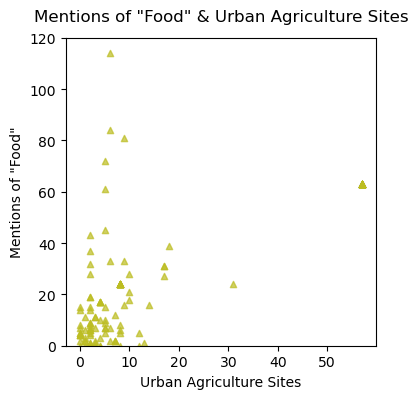

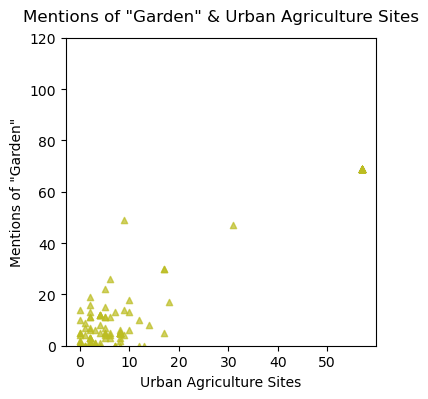

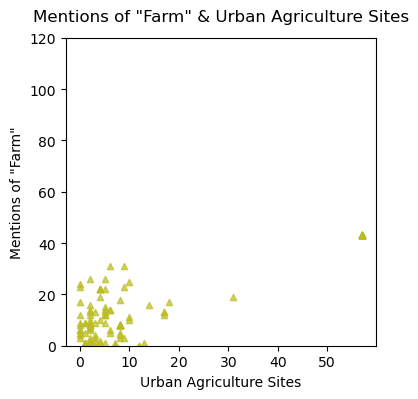

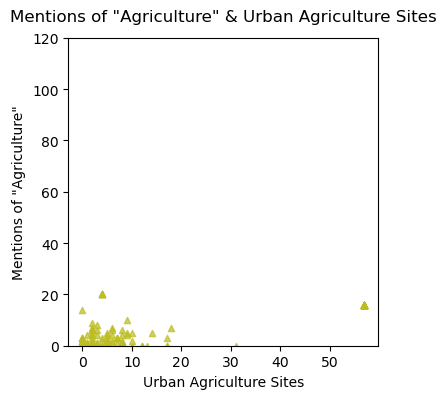

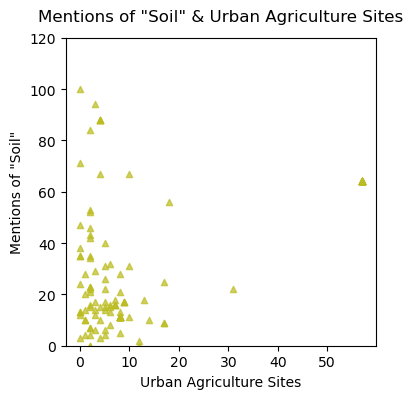

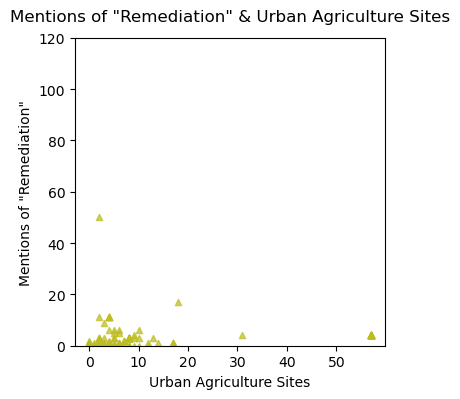

In [370]:
# scatterplots comparing density of urban ag sites and toxic release facilities and discharge totals to frequency of keyword mentions

keywords = ['food', 'garden', 'farm', 'agriculture', 'soil', 'remediation']

for key in keywords:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACmunikeys['UA Sites'], LACmunikeys[key], marker= '^', s= 20, c= 'tab:olive', alpha=0.7)
    
    plt.ylim([0, 120]) # designating y-range so differences between keywords are more obvious
    plt.title('Mentions of "{}" & Urban Agriculture Sites'.format(key.title()), pad= 12)
    plt.xlabel("Urban Agriculture Sites")
    plt.ylabel('Mentions of "{}"'.format(key.title()))

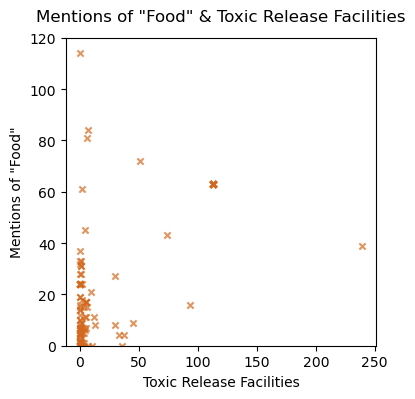

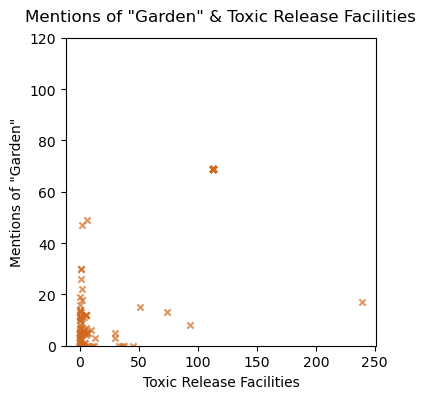

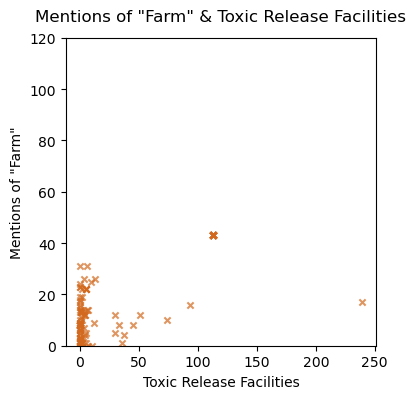

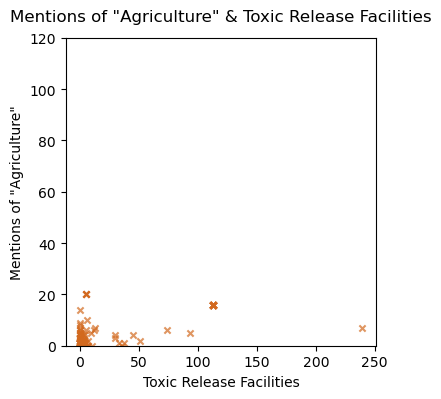

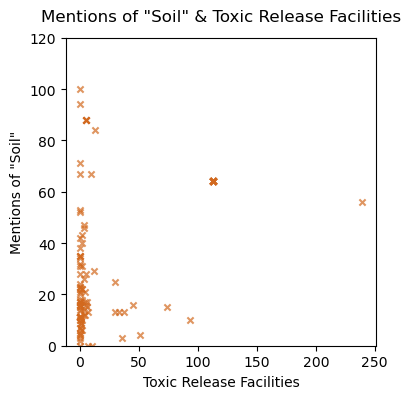

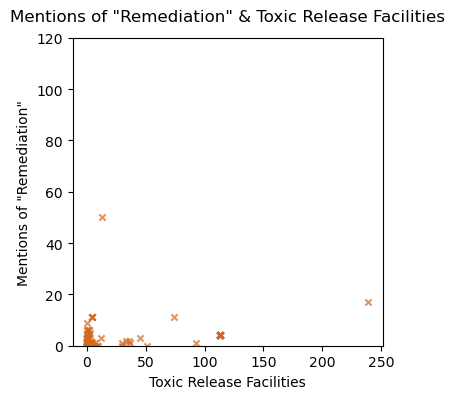

In [369]:
for key in keywords:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACmunikeys['Facilities'], LACmunikeys[key], marker= 'x', s= 20, c= '#D2691E', alpha=0.7)
    
    plt.ylim([0, 120]) # designating y-range so differences between keywords are more obvious
    plt.title('Mentions of "{}" & Toxic Release Facilities'.format(key.title()), pad= 12)
    plt.xlabel("Toxic Release Facilities")
    plt.ylabel('Mentions of "{}"'.format(key.title()))

In [238]:
# identifying the second largest value to reset the x-axis range for the scatterplot
# since the scatterplot with the max value is difficult to interpret
LACmunikeys['Release Total'].sort_values(ascending = False).head(5)

City
El Segundo    2.750826e+06
Carson        3.540392e+05
Torrance      3.117845e+05
Rosemead      1.430507e+05
Long Beach    4.312813e+04
Name: Release Total, dtype: float64

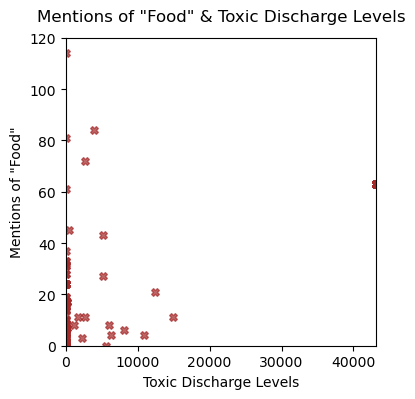

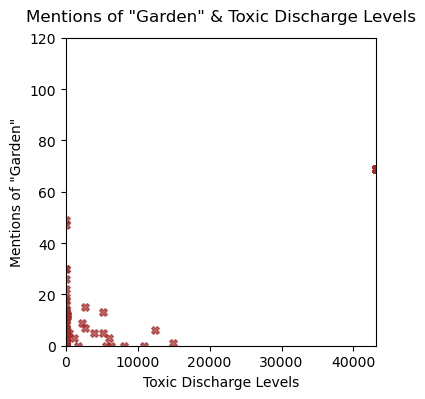

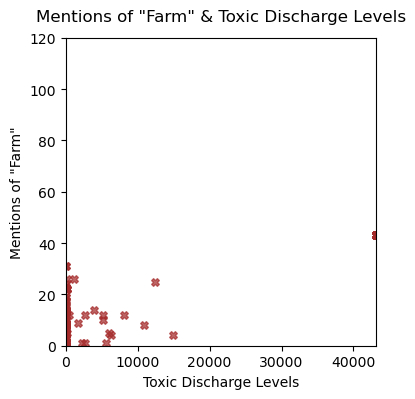

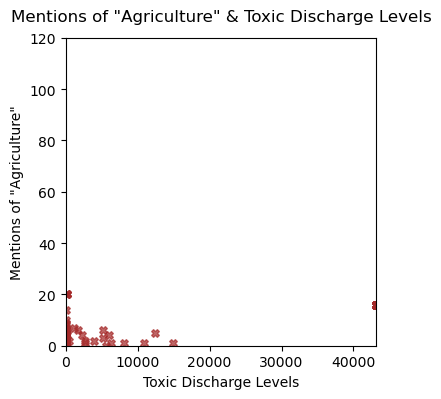

In [374]:
for key in keywords:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACmunikeys['Release Total'], LACmunikeys[key], marker= 'X', s= 30, c= '#A52A2A', alpha=0.7)
    
    plt.xlim([0, 4.312813e+04]) # resetting x-range so differences between keywords are more obvious
    plt.ylim([0, 120]) # designating y-range so differences between keywords are more obvious
    plt.title('Mentions of "{}" & Toxic Discharge Levels'.format(key.title()), pad=12)
    plt.xlabel("Toxic Discharge Levels")
    plt.ylabel('Mentions of "{}"'.format(key.title()))

### (B) Proximity of Keywords: How Are Cities Talking About Food & Urban Agriculture?

This next exercise aims to make inferences about whether or not food is being talked about in the context of land and environmental health based on the proximity between unique keywords -- essentially the number of words between two keywords in a unique keyword pair (e.g. "food" and "soil" or "food" and "safety"). 

For each plan, keyword pairs will be selected and simple matrix subtraction will be used to compare the distance between the individual words in those keyword pair sets. A matrix will be produced for each unique keyword pair -- resulting in 36 matrices for each plan -- including keyword pairs created from the following keyword sets:

    Set 1: FOOD, AGRICULTURE, GARDEN, FARM
    Set 2: safety, soil, sustainability, climate, environment, remediation, justice, public, residential
    
From these matrices, the number of times keywords in a unique pair are mentioned within 100 or less words of each other in each plan will ne calculated. This will be done with a cleaned wordlist for each plan instead of the raw text, given that distance measured in spaces would make it more difficult to estimate how many words are between each keyword.

The hope is that this method will allow me to identify where (which municipalities) are talking about food and community agriculture in the context of land and environmental health more generally.

In [68]:
# for each plan
keywords1 = ['food', 'garden', 'farm', 'agriculture']  
keywords2 = ['soil', 'remediation', 'sustainability', 'climate', 'environment', 'safety', 'justice',
            'public', 'residential']

# empty dictionary to hold the count of proximate occurrences
proxim = {}
# empty list to store set of occurrences for each city/plan
plan_col = []

for plan in genplan:
    
    # create a wordlist for each plan
    wordlist = [word for word in word_tokenize(plan.lower()) 
                 if word not in swords]
    
    # create dictionaries for keyword set 1 for each plan
    lposdict1 = {}
    for key1 in keywords1:
        # generate topic counts to populate dictionary frame indexed to topic
        positions1 = [i for i,w in enumerate(wordlist) if w.lower() == key1]
        lposdict1[key1] = positions1

    # create dictionaries for keyword set 2 for each plan
    lposdict2 = {}
    for key2 in keywords2:
        # generate topic counts to populate dictionary frame indexed to topic
        positions2 = [i for i,w in enumerate(wordlist) if w.lower() == key2]
        lposdict2[key2] = positions2
    
    # for each unique keyword pair created from the two keyword sets
    for key1, positions1 in lposdict1.items():
        for key2, positions2 in lposdict2.items():

            # create subtraction matrix for each keyword pair
            key1_key2 = abs(np.subtract(np.array(positions1), np.array(positions2)[:,None])) # with different array shapes
            # count occurences in each matrix where distance between keywords is <100 words + store in dictionary 
            proxim[key1, key2] = np.count_nonzero(key1_key2 < 100)
            # convert dictionary to dataframe series/column for each municipality
            prox = pd.DataFrame.from_dict(proxim, orient='index', columns=[plan.split(", ")[0]])
    
    # add each muni column generated to a single dataframe
    plan_col.append(prox)
    muniprox = pd.concat(plan_col, axis=1)

muniprox

Agoura Hills  Alhambra  Arcadia  Artesia  \
(food, soil)                              0         1        0        2   
(food, remediation)                       0         1        0        0   
(food, sustainability)                    1         0        2        5   
(food, climate)                           0         6        0        0   
(food, environment)                       0         2        1        8   
(food, safety)                            0        12        3        0   
(food, justice)                           0        13        0        0   
(food, public)                            0        15        4       16   
(food, residential)                       0         0        6        1   
(garden, soil)                            0         1        1        0   
(garden, remediation)                     0         0        0        0   
(garden, sustainability)                  0         1        1        0   
(garden, climate)                         0         3        0        0   
(garden, environment)                     0         1        0        0   
(garden, safety)                          0         0        4        4   
(garden, justice)                         0         0        0        0   
(garden, public)                          0         8        7        2   
(garden, residential)                     0         8        5        0   
(farm, soil)                              0         0        0        0   
(farm, remediation)                       0         0        0        0   
(farm, sustainability)                    0         0        0        0   
(farm, climate)                           0         0        0        0   
(farm, environment)                       0         1        1        1   
(farm, safety)                            1         1        0        0   
(farm, justice)                           0         0        0        0   
(farm, public)                            2         1        2        2   
(farm, residential)                       8         0        1        2   
(agriculture, soil)                       0         0        2        0   
(agriculture, remediation)                0         0        0        0   
(agriculture, sustainability)             0         0        0        0   
(agriculture, climate)                    0         0        0        0   
(agriculture, environment)                0         0        0        1   
(agriculture, safety)                     0         0        0        0   
(agriculture, justice)                    0         0        0        0   
(agriculture, public)                     0         0        0        6   
(agriculture, residential)                0         1        1       11   

                               Avalon  Azusa  Baldwin Park  Bell Gardens  \
(food, soil)                        0      1             1             0   
(food, remediation)                 0      0             0             0   
(food, sustainability)              0      0            37             0   
(food, climate)                     0      1             6             0   
(food, environment)                 0     12             4             1   
(food, safety)                      3      1             9             0   
(food, justice)                     0      0             0             0   
(food, public)                     11      9            58             1   
(food, residential)                 6     12             3            14   
(garden, soil)                      0      0             0             0   
(garden, remediation)               0      0             0             0   
(garden, sustainability)            0      0            10             0   
(garden, climate)                   0      0             0             0   
(garden, environment)               0      1             4             0   
(garden, safety)                    0      0             0             0   
(garden, justice)                   0  

In [242]:
# reorienting table so the keyword pair frequencies can be joined to other gdfs
muniproxt = muniprox.transpose()

# naming index
muniproxt.index.name = 'City'

# saving keyword pairs table
muniproxt.to_csv("Plan_Keyword_Proximities.csv")

In [264]:
# joining proximities table to the municipalities gdf
LACkeyprox = muniproxt.join(LAC, how = 'left')

# reconverting to a geodataframe
LACkeyprox = gpd.GeoDataFrame(LACkeyprox, geometry = "geometry", crs='EPSG:4326')

In [266]:
# inspect/show
LACkeyprox.head(1)

(food, soil)  (food, remediation)  (food, sustainability)  \
City                                                                      
Agoura Hills             0                    0                       1   

              (food, climate)  (food, environment)  (food, safety)  \
City                                                                 
Agoura Hills                0                    0               0   

              (food, justice)  (food, public)  (food, residential)  \
City                                                                 
Agoura Hills                0               0                    0   

              (garden, soil)  (garden, remediation)  (garden, sustainability)  \
City                                                                            
Agoura Hills               0                      0                         0   

              (garden, climate)  (garden, environment)  (garden, safety)  \
City                                                                       
Agoura Hills                  0                      0                 0   

              (garden, justice)  (garden, public)  (garden, residential)  \
City                                                                       
Agoura Hills                  0                 0                      0   

              (farm, soil)  (farm, remediation)  (farm, sustainability)  \
City                                                                      
Agoura Hills             0                    0                       0   

              (farm, climate)  (farm, environment)  (farm, safety)  \
City                                                                 
Agoura Hills                0                    0               1   

              (farm, justice)  (farm, public)  (farm, residential)  \
City                                                                 
Agoura Hills                0               2                    8   

              (agriculture, soil)  (agriculture, remediation)  \
City                                                            
Agoura Hills                    0                           0   

              (agriculture, sustainability)  (agriculture, climate)  \
City                                                                  
Agoura Hills                              0                       0   

              (agriculture, environment)  (agriculture, safety)  \
City                                                              
Agoura Hills                           0                      0   

              (agriculture, justice)  (agriculture, public)  \
City                                                          
Agoura Hills                       0                      0   

              (agriculture, residential)  Facilities  Release Total  UA Sites  \
City                                                                            
Agoura Hills                           0         0.0            0.0       3.0   

                   County               Region  \
City                                             
Agoura Hills  Los Angeles  Southern California   

                                                       geometry  
City                                                             
Agoura Hills  POLYGON ((-118.72864 34.16793, -118.73666 34.1...

#### Visualizing Frequency of Proximate Food-Environment Keyword Pairs

To get a better sense of which cities might be considering food as a land use and environmental management issue in their long-range land use planning  goals and strategies, the table above will be used to produce maps showing the distribution of keyword pairs frequencies (how often the keywords in a pair are talked about closely together in land use plans) to see how these frequencies might be distributed across cities in LA County. 

As with the keyword count table and maps, the keyword proximities table will be merged with a table that includes LA County city boundaries and preliminary information about the density of urban agriculture sites and facilities that produce toxic waste in a given city (created in the "LAC Map" notebook). (*Note: It was easier -- for the purposes of scrolling through and finding keywords and keypairs -- to keep these two tables separate than to merge them together into one geodataframe.*)

However, because the process of creating the keyword proximities table required using the keyword dictionary tuple labels as column names (which result in columns that are not "callable"), the column names will first need to be converted from tuple form to a simple string.

In [274]:
# removing special characters in tuples column names
LACkeyprox.columns = LACkeyprox.columns.astype('string')
LACkeyprox.columns = LACkeyprox.columns.str.strip('(').str.strip(')').str.replace("'","").str.replace(', ','_')
LACkeyprox.head(1) 

food_soil                   food_remediation            \
City                                                                   
Agoura Hills                           0                           0   

              food_sustainability         food_climate                \
City                                                                   
Agoura Hills                           1                           0   

              food_environment            food_safety                 \
City                                                                   
Agoura Hills                           0                           0   

              food_justice                food_public                 \
City                                                                   
Agoura Hills                           0                           0   

              food_residential            garden_soil                 \
City                                                                   
Agoura Hills                           0                           0   

              garden_remediation          garden_sustainability       \
City                                                                   
Agoura Hills                           0                           0   

              garden_climate              garden_environment          \
City                                                                   
Agoura Hills                           0                           0   

              garden_safety               garden_justice              \
City                                                                   
Agoura Hills                           0                           0   

              garden_public               garden_residential          \
City                                                                   
Agoura Hills                           0                           0   

              farm_soil                   farm_remediation            \
City                                                                   
Agoura Hills                           0                           0   

              farm_sustainability         farm_climate                \
City                                                                   
Agoura Hills                           0                           0   

              farm_environment            farm_safety                 \
City                                                                   
Agoura Hills                           0                           1   

              farm_justice                farm_public                 \
City                                                                   
Agoura Hills                           0                           2   

              farm_residential            agriculture_soil            \
City                                                                   
Agoura Hills                           8                           0   

              agriculture_remediation     agriculture_sustainability  \
City                                                                   
Agoura Hills                           0                           0   

              agriculture_climate         agriculture_environment     \
City                                                                   
Agoura Hills                           0                           0   

              agriculture_safety          agriculture_justice         \
City                                                                   
Agoura Hills                           0                           0   

              agriculture_public          agriculture_residential     \
City                                                                   
Agoura Hills                           0                           0   

              Facilities                  Release Total               \
City                                

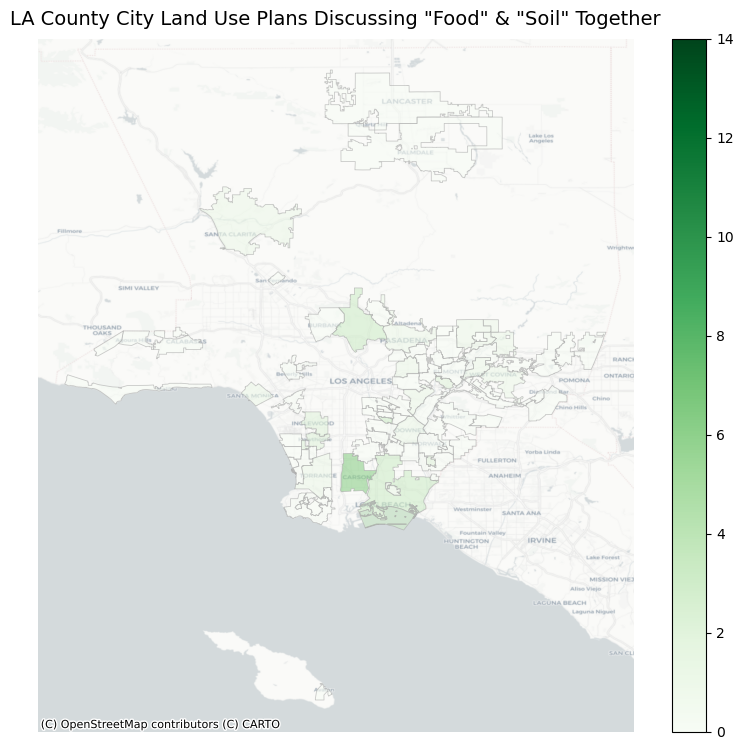

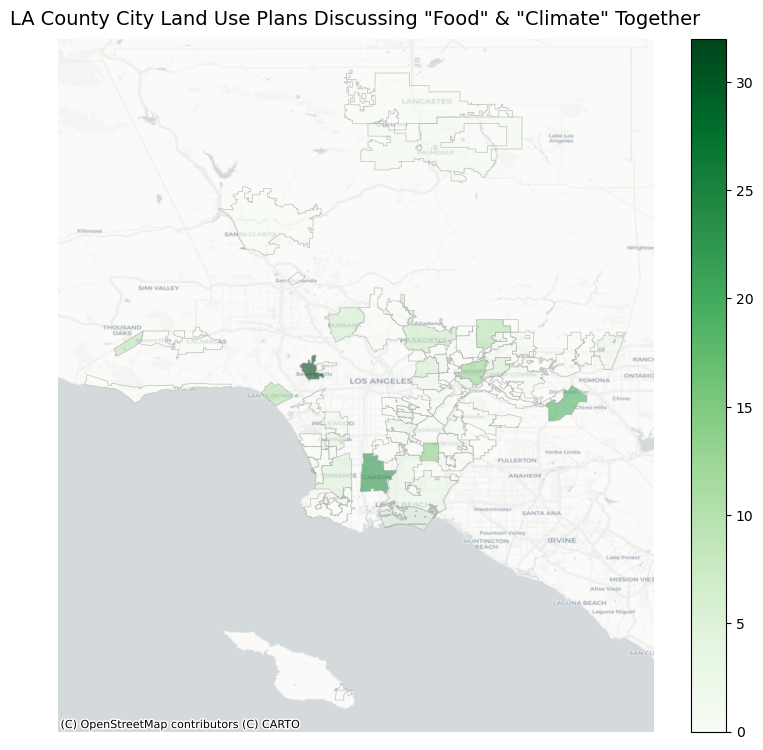

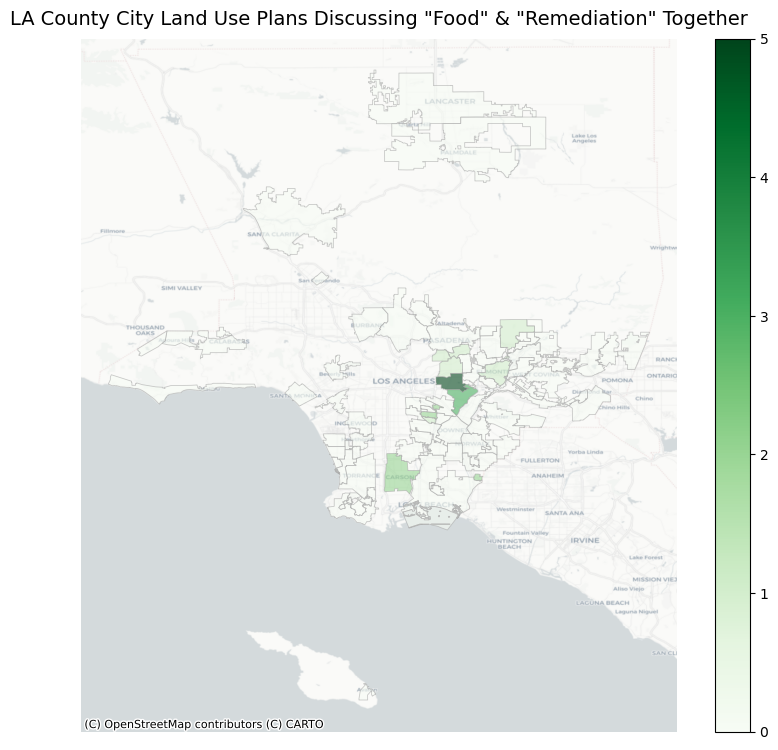

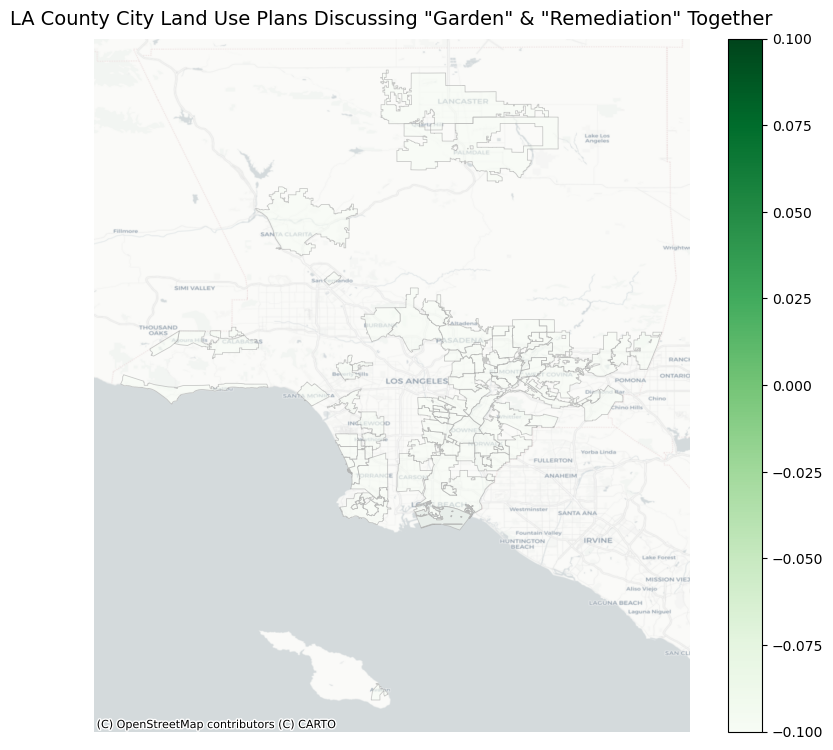

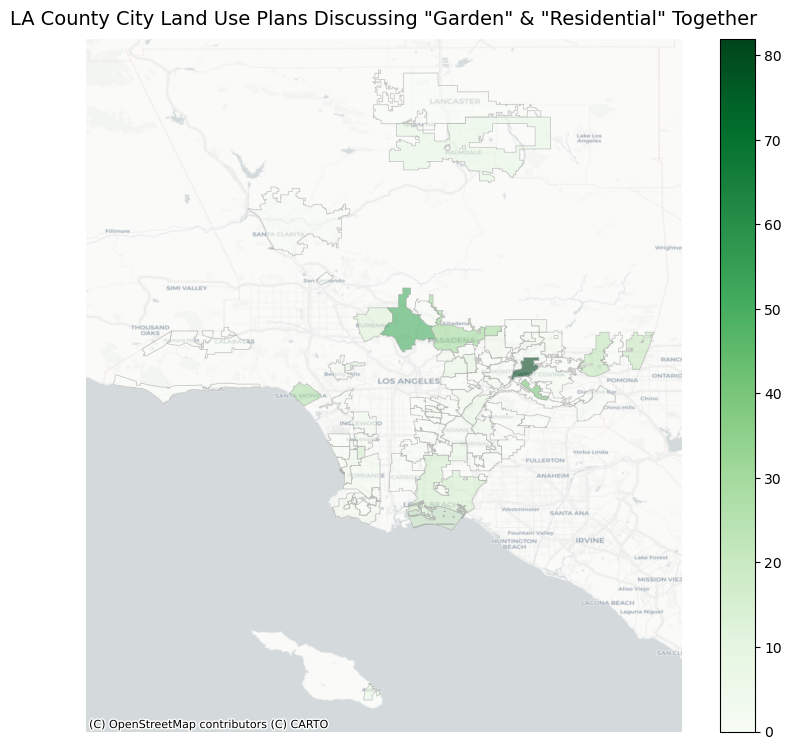

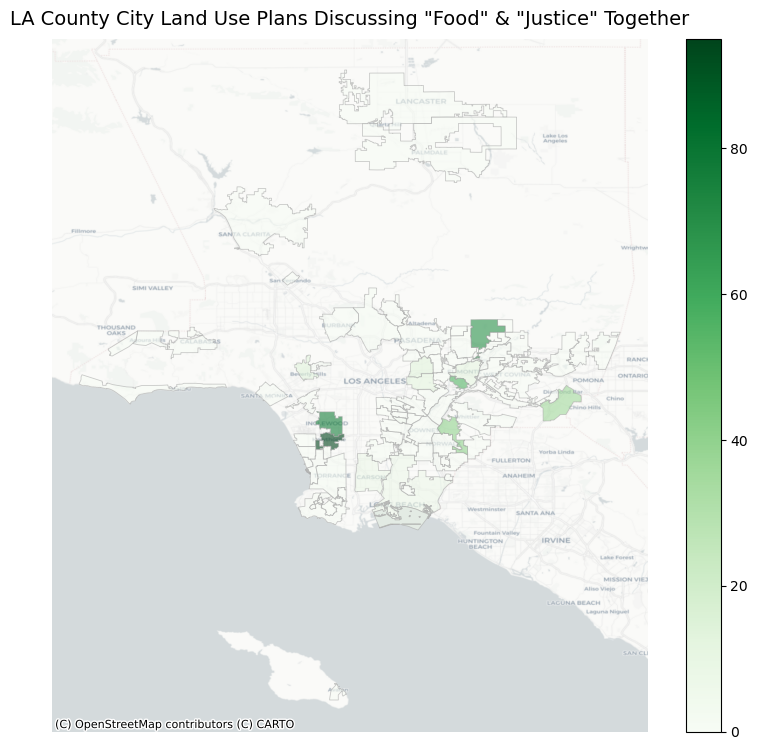

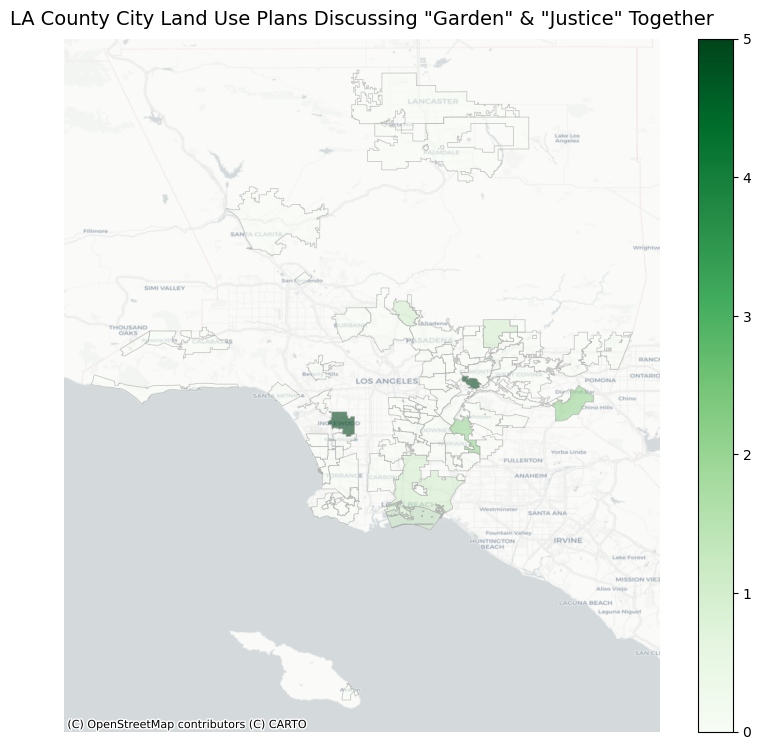

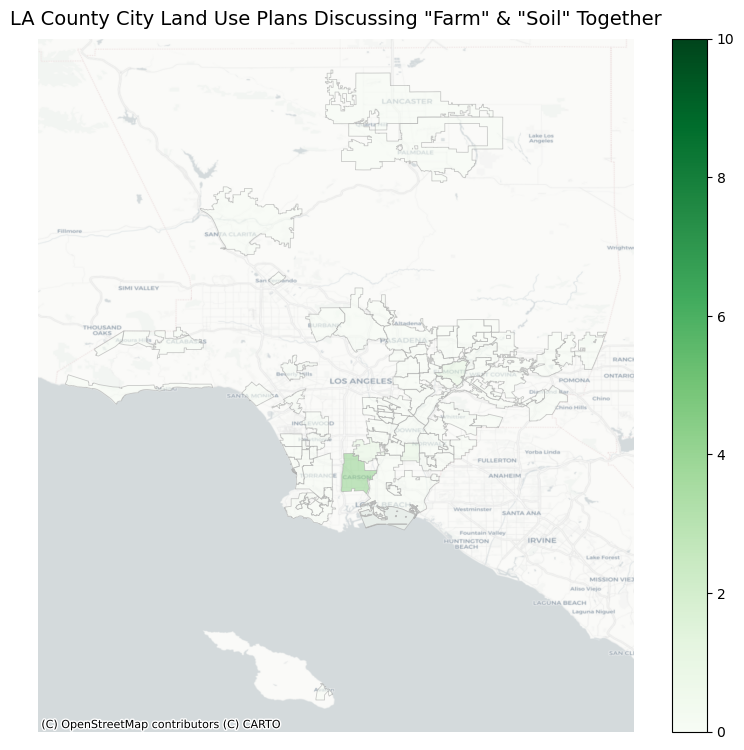

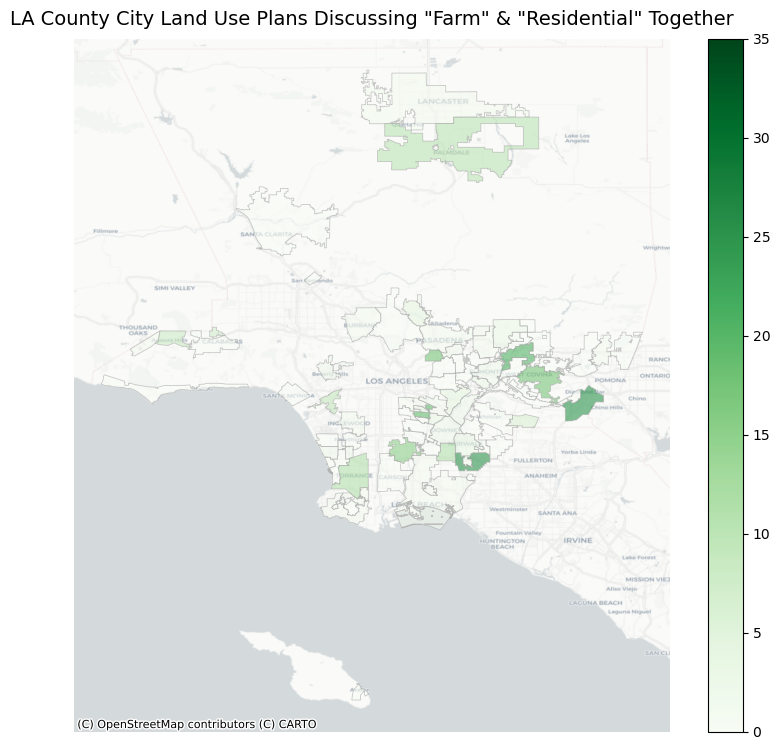

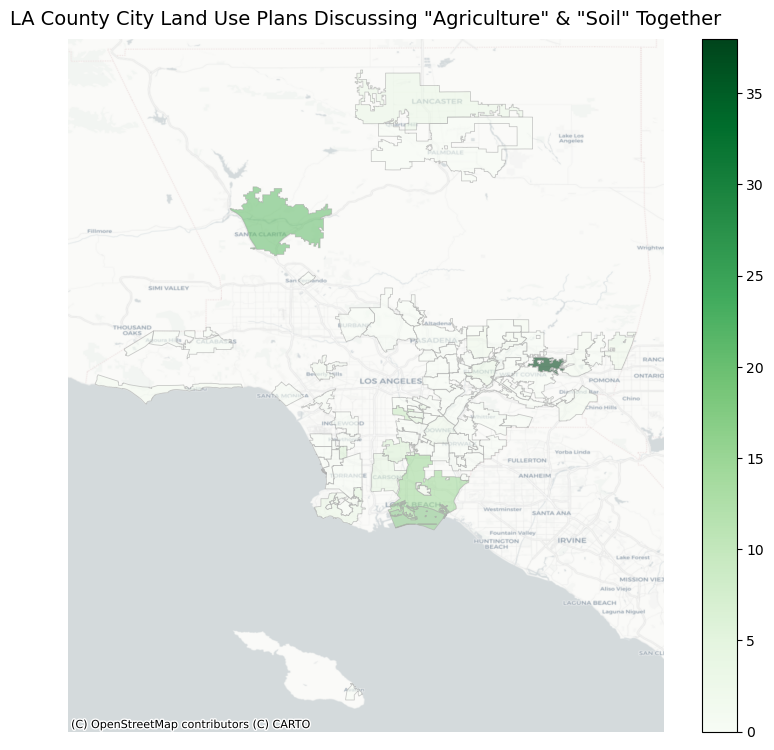

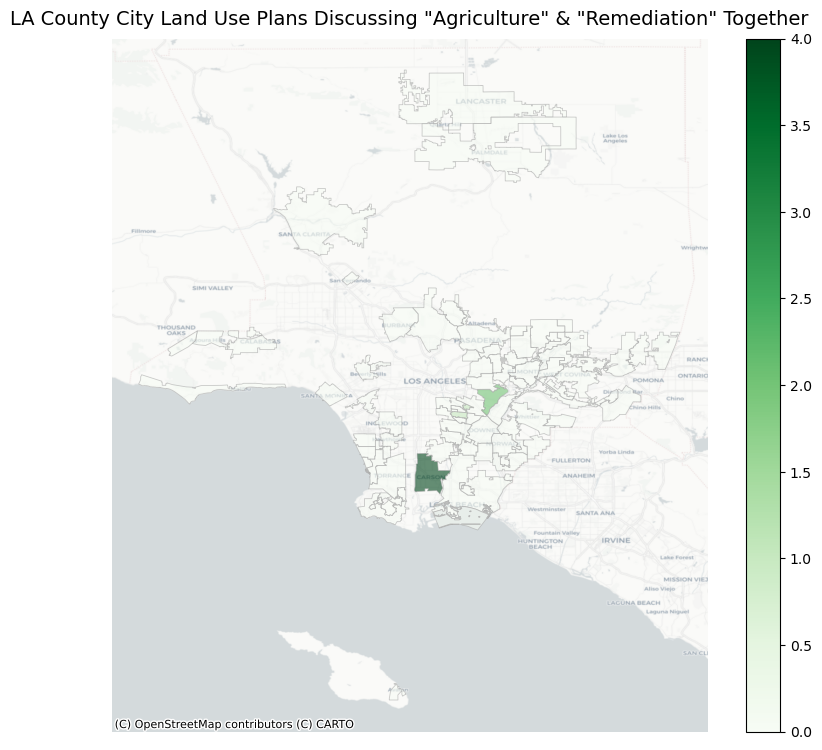

In [382]:
# loop to generate maps for each keyword pair

keypair = ['food_soil', 'food_climate', 'food_remediation', 'garden_remediation', 
           'garden_residential', 'food_justice', 'garden_justice', 'farm_soil', 'farm_residential', 
           'agriculture_soil', 'agriculture_remediation']

for pair in keypair:
    fig, ax = plt.subplots(figsize =(10,9))
    
    # keyword
    LACkeyprox.plot(ax=ax,
                     column = pair,
                     edgecolor = 'darkgrey',
                     linewidth = .6,
                     cmap = 'Greens',
                     alpha = .6,
                     legend = True)
    
    # customizations
    ax.axis('off')
    ax.set_title('LA County City Land Use Plans Discussing "{}" & "{}" Together'.
                 format(pair.split("_")[0].title(), pair.split("_")[1].title()),
                 fontsize=14, pad=10)
    
    # basemap
    ctx.add_basemap(ax, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)

The following sets of scatterplots aim to explore the relationship between how often a city's land use plan talks about local food production and land/environmental health together (as inferred by the number of times two food- and environment-related keywords appear within ~100 words of each other) and (1) the number of urban agriculture sites, (2) the number of toxic release emitting facilities, and (3) on-site toxic release discharge totals by those facilities.

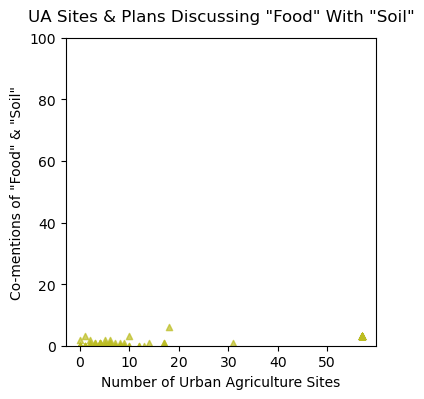

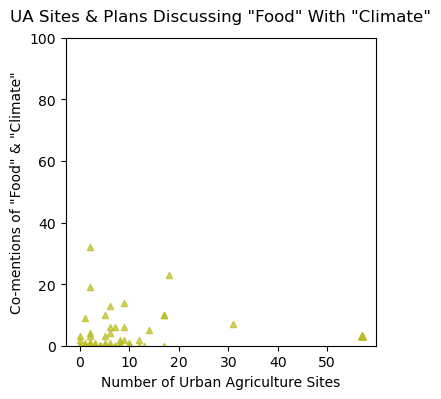

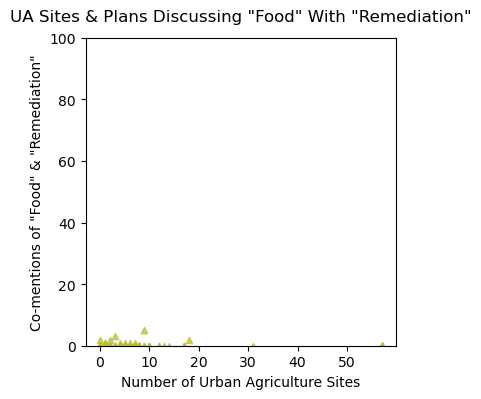

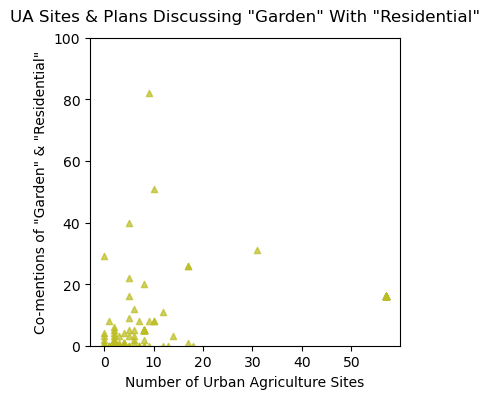

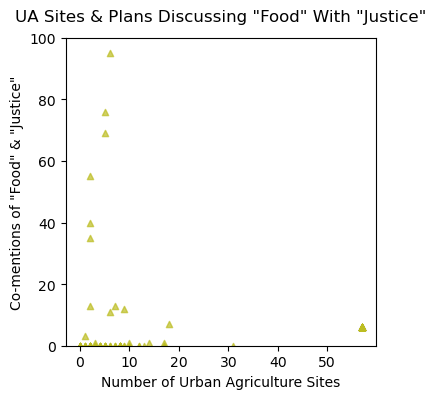

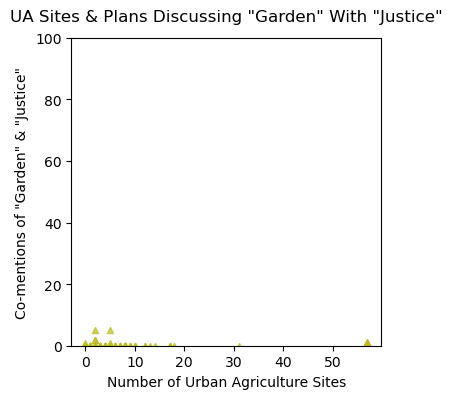

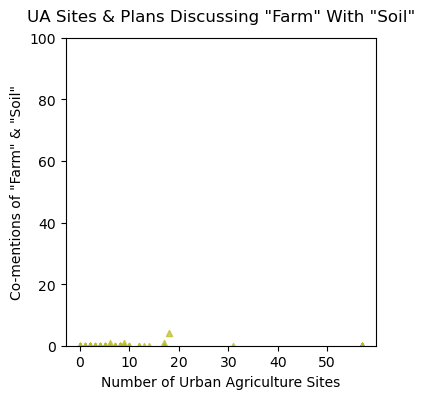

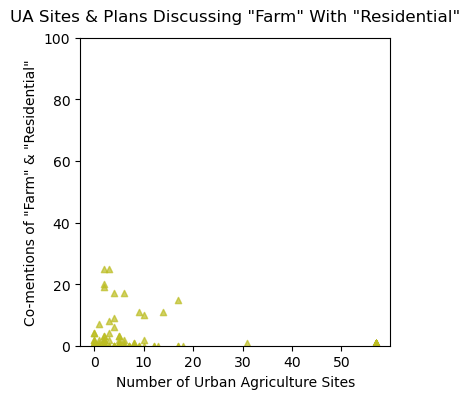

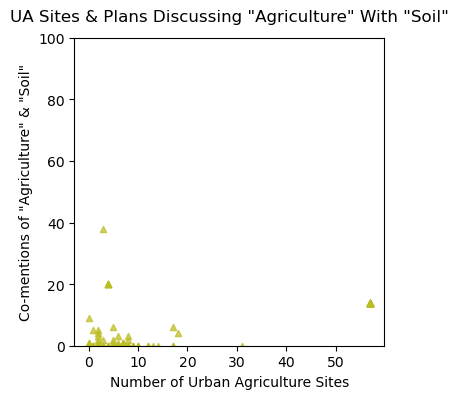

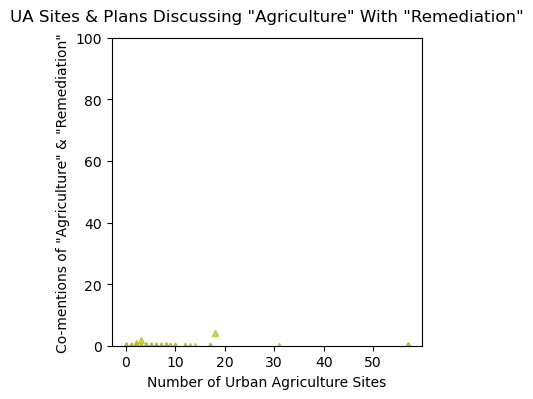

In [375]:
# scatterplots comparing density of urban ag sites to frequency of key pairs

keypair = ['food_soil', 'food_climate', 'food_remediation', 
           'garden_residential', 'food_justice', 'garden_justice', 'farm_soil', 'farm_residential', 
           'agriculture_soil', 'agriculture_remediation']

for pair in keypair:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACkeyprox['UA Sites'], LACkeyprox[pair], marker= '^', s= 20, c= 'tab:olive', alpha=0.7)
    
    plt.ylim([0, 100]) # designating y-range so differences between pairs are more obvious
    plt.title('UA Sites & Plans Discussing "{}" With "{}"'.
                 format(pair.split("_")[0].title(), pair.split("_")[1].title()), pad= 12)
    plt.xlabel("Number of Urban Agriculture Sites")
    plt.ylabel('Co-mentions of "{}" & "{}"'.
                 format(pair.split("_")[0].title(), pair.split("_")[1].title()))

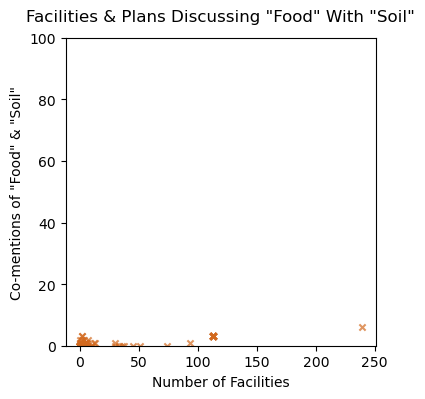

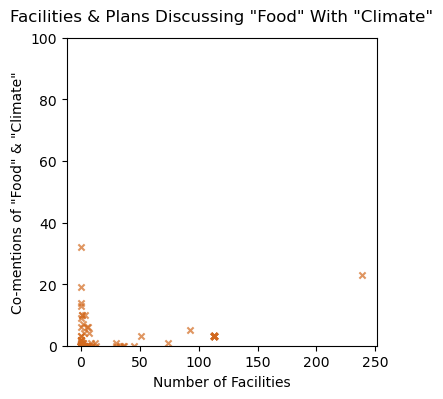

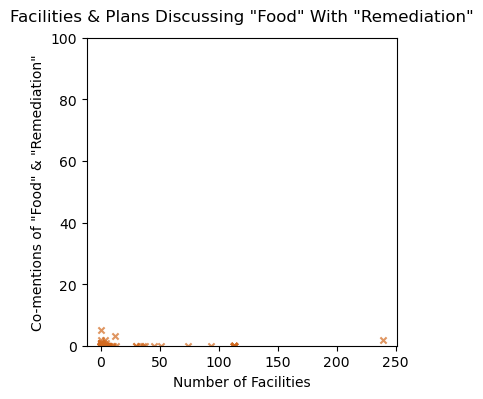

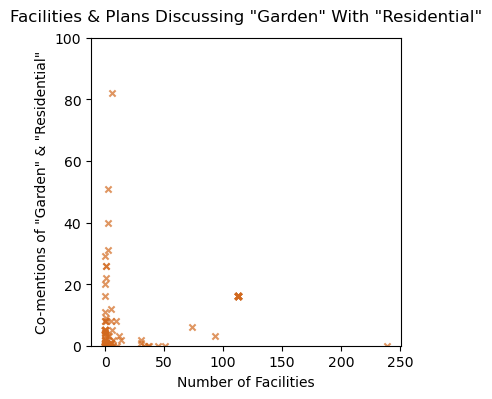

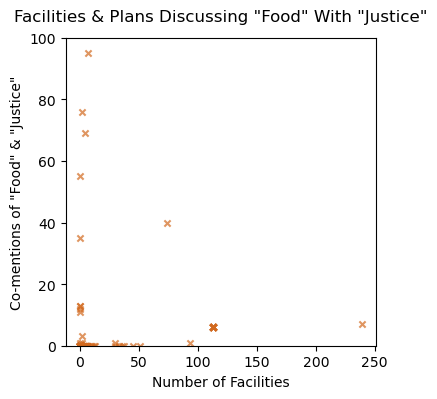

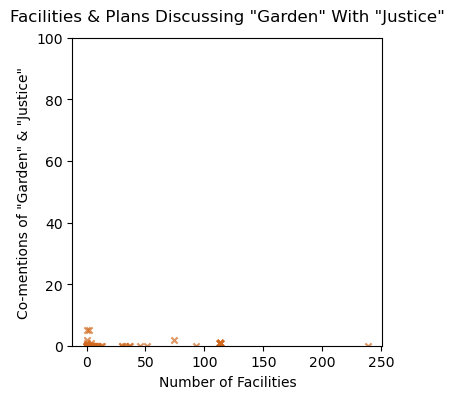

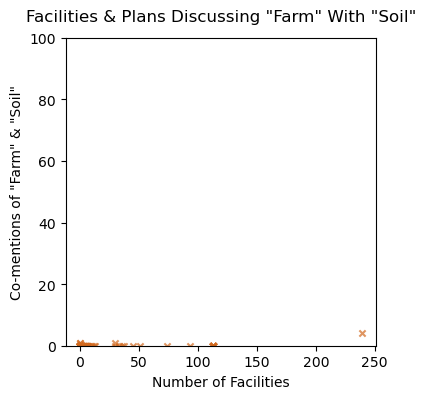

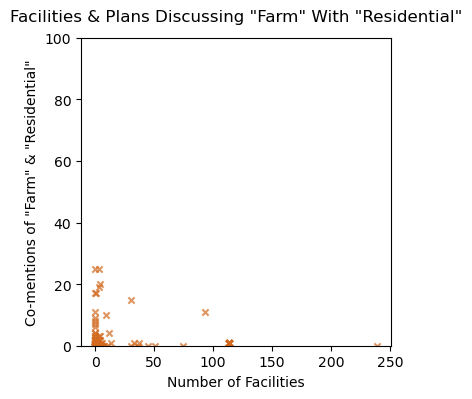

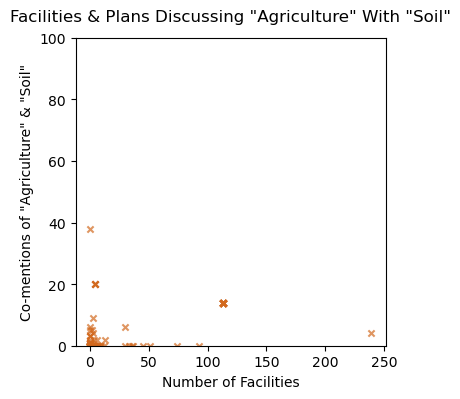

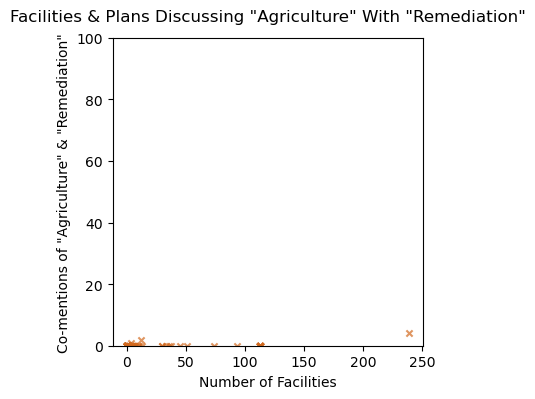

In [376]:
# scatterplots comparing density of toxic release facilities to frequency of key pairs

keypair = ['food_soil', 'food_climate', 'food_remediation', 
           'garden_residential', 'food_justice', 'garden_justice', 'farm_soil', 'farm_residential', 
           'agriculture_soil', 'agriculture_remediation']

for pair in keypair:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACkeyprox['Facilities'], LACkeyprox[pair], marker= 'x', s= 20, c= '#D2691E', alpha=0.7)
    
    plt.ylim([0, 100]) # designating y-range so differences between pairs are more obvious
    plt.title('Facilities & Plans Discussing "{}" With "{}"'.
                 format(pair.split("_")[0].title(), pair.split("_")[1].title()), pad= 12)
    plt.xlabel("Number of Facilities")
    plt.ylabel('Co-mentions of "{}" & "{}"'.
                 format(pair.split("_")[0].title(), pair.split("_")[1].title()))

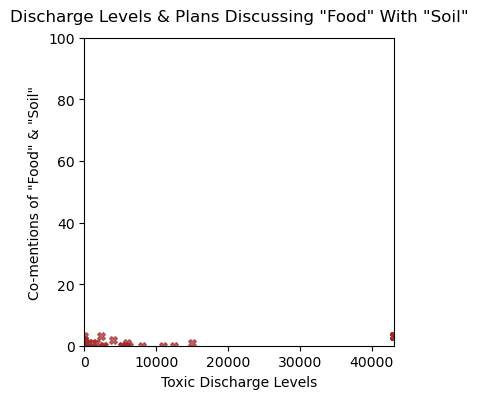

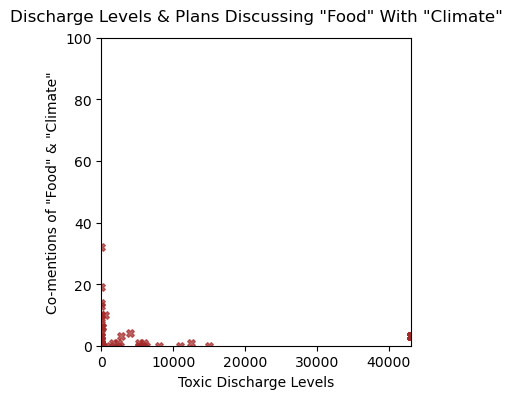

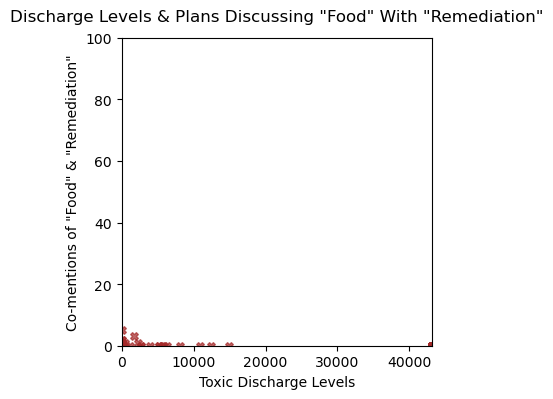

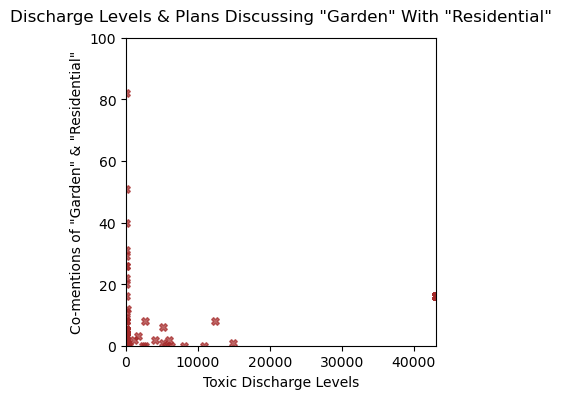

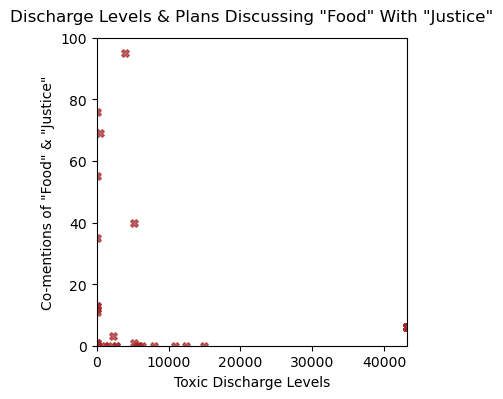

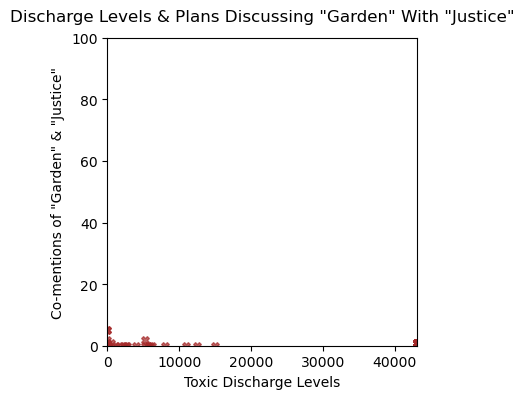

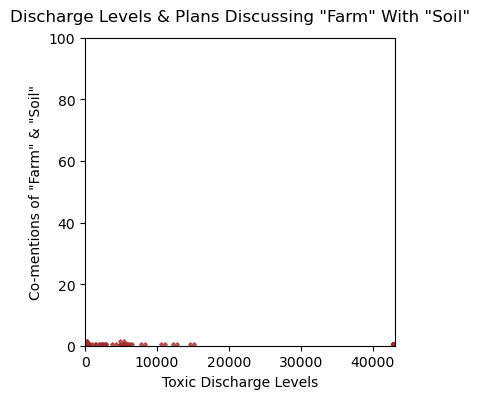

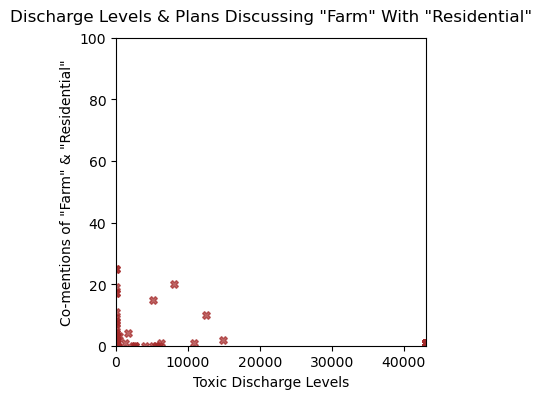

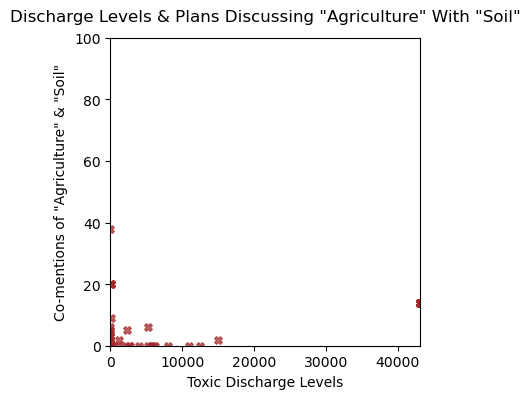

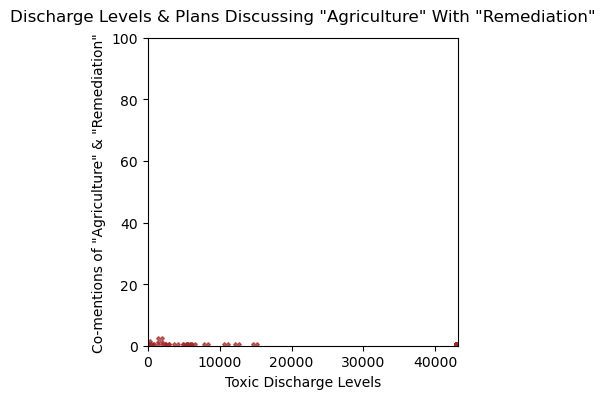

In [377]:
# scatterplots comparing density toxic release discharge totals to frequency of key pairs

keypair = ['food_soil', 'food_climate', 'food_remediation', 
           'garden_residential', 'food_justice', 'garden_justice', 'farm_soil', 'farm_residential', 
           'agriculture_soil', 'agriculture_remediation']

for pair in keypair:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACkeyprox['Release Total'], LACkeyprox[pair], marker= 'X', s= 30, c= '#A52A2A', alpha=0.7)
    
    plt.xlim([0, 4.312813e+04]) # resetting x-range so differences between keywords are more obvious
    plt.ylim([0, 100]) # designating y-range so differences between pairs are more obvious
    plt.title('Discharge Levels & Plans Discussing "{}" With "{}"'.
                 format(pair.split("_")[0].title(), pair.split("_")[1].title()), pad= 12)
    plt.xlabel("Toxic Discharge Levels")
    plt.ylabel('Co-mentions of "{}" & "{}"'.
                 format(pair.split("_")[0].title(), pair.split("_")[1].title()))

Now, comparing both sets of maps showing the distribution of (1) keyword mentions and (2) proximity of keywords related to community food production to the maps below illustrating both the density/distribution of urban agriculture sites and facilities producing toxic waste across all the municipalities in LA County, it becomes clear that ...

C:\Users\melod\Programs\envs\uds\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


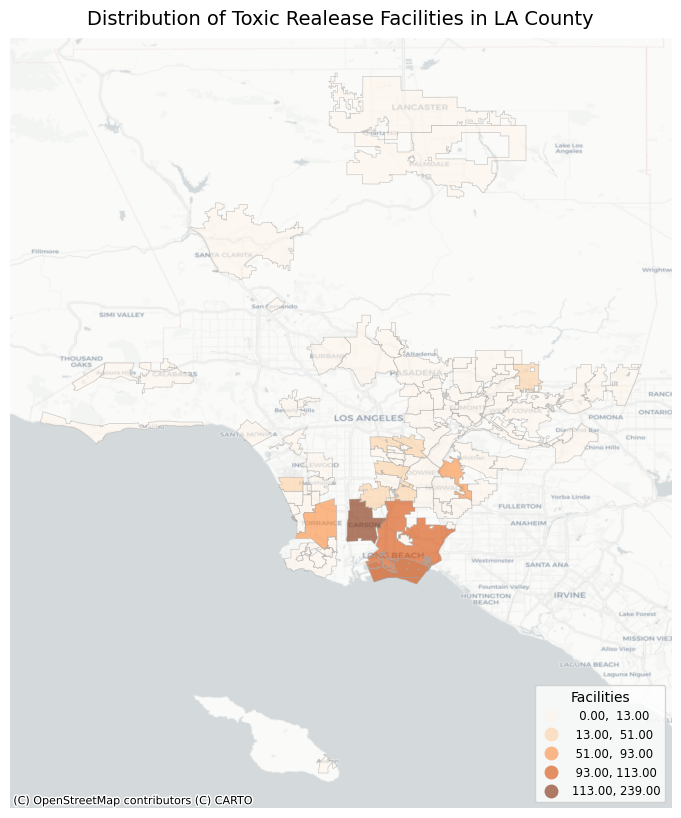

In [378]:
# Toxic release choropleth map
fig, ax = plt.subplots(figsize=(9,10))

# tox release layer
LACmunikeys.plot(ax=ax,
                column= 'Facilities',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Oranges',
                scheme = 'NaturalBreaks',
                alpha=.6,
                legend= True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Toxic Realease Facilities in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Facilities')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

C:\Users\melod\Programs\envs\uds\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


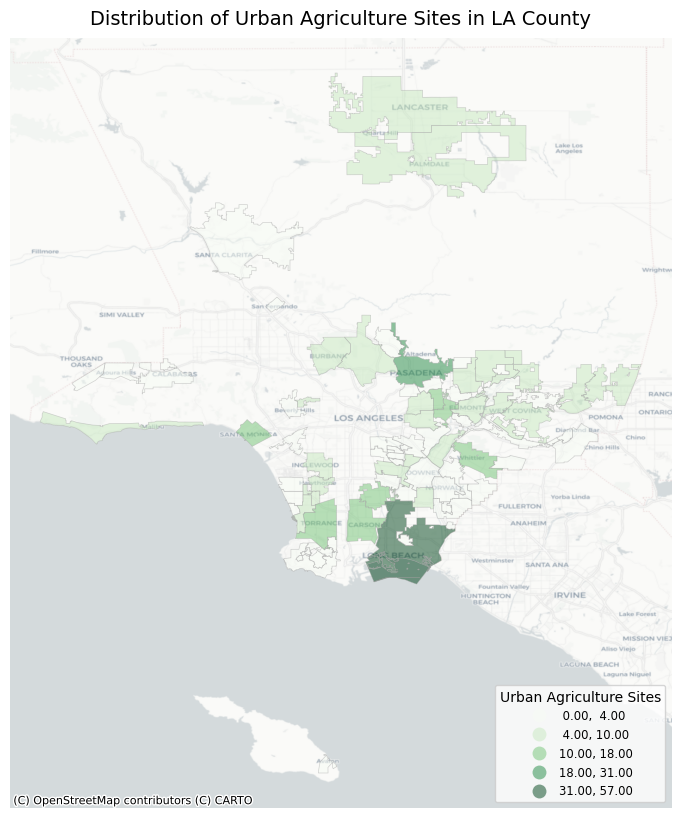

In [379]:
# Urban ag choropleth map
fig, ax = plt.subplots(figsize=(9,10))

# urban ag layer
LACkeyprox.plot(ax=ax,
                column= 'UA Sites',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Greens',
                scheme = 'NaturalBreaks',
                alpha=.5,
                legend=True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Urban Agriculture Sites in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Urban Agriculture Sites')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

C:\Users\melod\Programs\envs\uds\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


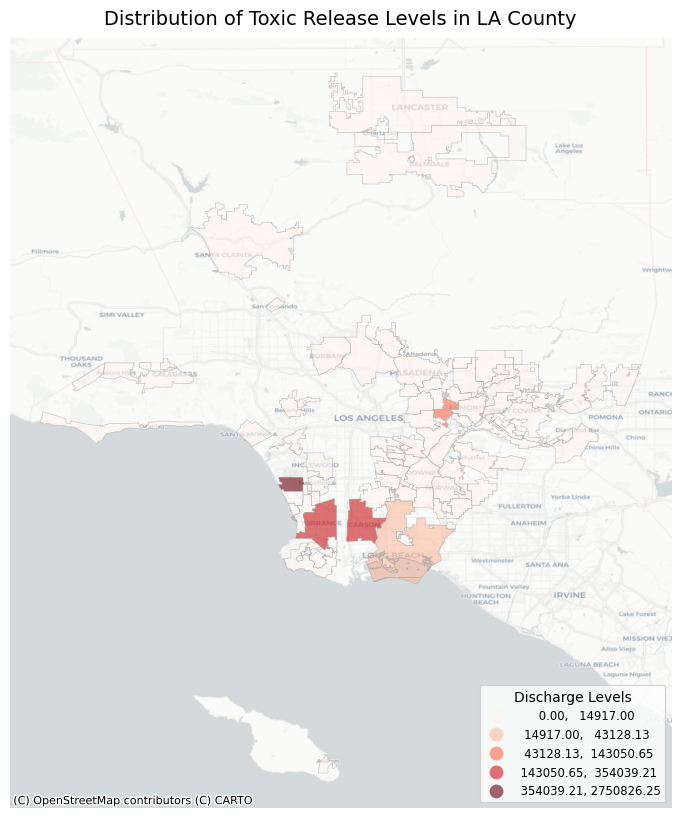

In [380]:
# Toxic release choropleth map
fig, ax = plt.subplots(figsize=(9,10))

# tox release layer
LACkeyprox.plot(ax=ax,
                column= 'Release Total',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Reds',
                scheme='NaturalBreaks',
                alpha=.6,
                legend= True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Toxic Release Levels in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Discharge Levels')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

In [315]:
# creating City column that can be called (since the index column containing the city names cannot be)
LACmunikeys['City'] = LACmunikeys.index
LACkeyprox['City'] = LACkeyprox.index

In [321]:
# Identifying the city with the highest number of mentions in all five counties:

# keyword mentions
keywords = ['food', 'garden', 'farm', 'agriculture', 'soil', 'remediation']

for key in keywords:
    print('Most mentions of "{}": {}'.
          format(key, LACmunikeys.loc[LACmunikeys[key] == LACmunikeys[key].max(), 'City']))

# keyword pairs
keypair = ['food_soil', 'food_climate', 'food_remediation', 
           'garden_residential', 'garden_justice', 'farm_soil', 'farm_residential', 
           'agriculture_soil', 'agriculture_remediation']

for pair in keypair:
    print('Most mentions of "{}": {}'.
          format(pair, LACkeyprox.loc[LACkeyprox[pair] == LACkeyprox[pair].max(), 'City']))

Most mentions of "food": City
El Monte    El Monte
Name: City, dtype: object
Most mentions of "garden": City
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Name: City, dtype: object
Most mentions of "farm": City
Camarillo    Camarillo
Name: City, dtype: object
Most mentions of "agriculture": City
Camarillo    Camarillo
Name: City, dtype: object
Most mentions of "soil": City
Thousand Oaks    Thousand Oaks
Name: City, dtype: object
Most mentions of "remediation": City
Signal Hill    Signal Hill
Name: City, dtype: objec

In [320]:
# creating gdfs that limit cities to LA County
LACkeyprox1 = LACkeyprox[LACkeyprox['County'] == 'Los Angeles']
LACmunikeys1 = LACmunikeys[LACmunikeys['County'] == 'Los Angeles']

In [368]:
# Identifying the city with the highest number of mentions in LA County only:

# land and community food system features
features = ['UA Sites', 'Facilities', 'Release Total']

for feature in features:
    print('Highest "{}": {}'.
          format(feature, LACmunikeys1.loc[LACmunikeys1[feature] == LACmunikeys1[feature].max(), 'City']))

# keyword mentions
keywords = ['food', 'garden', 'farm', 'agriculture', 'soil', 'remediation']

for key in keywords:
    print('Most mentions of "{}": {}'.
          format(key, LACmunikeys1.loc[LACmunikeys1[key] == LACmunikeys1[key].max(), 'City']))

# keyword pairs
keypair = ['food_soil', 'food_climate', 'food_remediation', 
           'garden_residential', 'garden_justice', 'farm_soil', 'farm_residential', 
           'agriculture_soil', 'agriculture_remediation']

for pair in keypair:
    print('Most mentions of "{}": {}'.
          format(pair, LACkeyprox1.loc[LACkeyprox1[pair] == LACkeyprox1[pair].max(), 'City']))

Highest "UA Sites": City
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Name: City, dtype: object
Highest "Facilities": City
Carson    Carson
Name: City, dtype: object
Highest "Release Total": City
El Segundo    El Segundo
Name: City, dtype: object
Most mentions of "food": City
El Monte    El Monte
Name: City, dtype: object
Most mentions of "garden": City
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    Long Beach
Long Beach    

ANALYSIS...

### (C) Modified Topic Modeling: How Are Cities Treating Food & Urban Agriculture as Policy Priority?

The previous exercise focused on identifying/verifying whether food and urban agriculture was being talked about in relation to a specific set of topics and keywords (health, safety, sustainability, climate). This last exercise is meant to be a variation on topic modeling that focuses agnostically on finding the common words/topics mentioned around food and urban agriculture in general plans to gauge how food is being discussed more generally in city land use planning.

A small subset of keywords related to community food production have been selected for this purpose. The positions for all unique mentions of each keyword in each plan will be identified and word segments will be created around each of these unique keyword mentions (approximately 100 words both behind and in front of the keyword (~400 characters)). 

Each of these plan segments (containing a unique mention of the keyword) will be saved into a list of segments and passed through GENSIM for topic modeling -- in the hopes the results may provide some more general insight about the contexts in which these plans may be discussing "food" and community food production.

In [120]:
# creating a keyword subset dictionary for topic modeling purposes

# create empty dictionary to store keyword positions lists
textdictsub = {}
# create empty dictionary to store created word segments around each keyword
allsegs = {}

keyloc = ['food', 'garden', 'farm', 'agriculture', 'fruit', 'vegetable', 'animal']

for plan in genplan:
    for key in keyloc:
        # identify position for each keyword in the raw text text
        textpositionsub = [i for i in range(len(plan)) if plan.startswith(key, i)] # adapted: https://www.geeksforgeeks.org/python-all-occurrences-of-substring-in-string/#
        # save to a dictionary
        textdictsub[key, plan.split(", ")[0]] = textpositionsub

    # for each unique keyword mention in each plan, create a segment of +/- 100 words around the keyword
    for keyword, positions in textdictsub.items():
        for position in positions:
            # add row to dict for ea unique key mention and corresponding word segments
            allsegs[keyword, position] = plan[position-400:position+400]
            
        # turn dict into df: store ea segment for ea keyword in keyloc (for ea plan in genplan)
        allsegsdf = pd.DataFrame.from_dict(allsegs, orient='index', columns=['segment'])
        
#inspect/show
allsegsdf

segment
((food, Agoura Hills), 78416)    ood community and regional commercial centers ...
((food, Agoura Hills), 250815)   urage the development of childcare facilities ...
((farm, Agoura Hills), 91550)    nagement strategy that accommodates change in ...
((farm, Agoura Hills), 92945)    ith sufficient land to accommodate the Towns g...
((animal, Agoura Hills), 55924)  esource Parks and Recreation PR FAR Open Space...
...                                                                            ...
((animal, Windsor), 260448)      rt and advocate efforts by the Sonoma County A...
((animal, Windsor), 277519)      l and aesthetic values As development pressure...
((animal, Windsor), 277906)      us plant and animal species including special ...
((animal, Windsor), 278118)      icies in this section guide the Town in the pr...
((animal, Windsor), 472043)       items from households and businesses Solid wa...

[5609 rows x 1 columns]

In [124]:
# converting the list of segments in the dataframe (the segment series) into a list of strings
allsegslist = allsegsdf.segment.values

# identifying more words to exclude
words_to_exclude = ['shall','area','windsor', 'plan']

# turning list of segment strings into a list of segment lists
# list of strings: ea string is a narrow word segment surrounding each unique keyword mention
planseglists = [[word for word in word_tokenize(seg.lower())
                 if word not in swords and word not in words_to_exclude
                 and len(word)>2] for seg in allsegslist]

In [122]:
print('There are {} total segments in planseglists.'.format(len(planseglists)))

There are 5609 total segments in planseglists.


Now, the list of segments for all unique keyword mentions for each keyword for each plan will be passed through GENSIM for topic modeling.

In [125]:
# generating topic model: start w/ 5 topics
dictionary = gensim.corpora.Dictionary(planseglists)
corpus = [dictionary.doc2bow(planseg) for planseg in planseglists]
# LdaMulticore uses multiple cores (thus, it runs faster); if you have problems, try replacing LdaMulticore with LdaModel
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5)

# show topics
model.show_topics()

[(0,
  '0.027*"town" + 0.011*"development" + 0.009*"use" + 0.009*"community" + 0.008*"public" + 0.008*"land" + 0.007*"general" + 0.007*"density" + 0.007*"residential" + 0.007*"housing"'),
 (1,
  '0.019*"town" + 0.013*"development" + 0.010*"general" + 0.010*"public" + 0.010*"use" + 0.009*"areas" + 0.009*"residential" + 0.009*"pfs" + 0.008*"uses" + 0.006*"land"'),
 (2,
  '0.037*"town" + 0.017*"development" + 0.017*"general" + 0.010*"policies" + 0.008*"housing" + 0.008*"implementation" + 0.008*"policy" + 0.007*"community" + 0.007*"adopted" + 0.007*"public"'),
 (3,
  '0.033*"town" + 0.011*"use" + 0.010*"development" + 0.009*"public" + 0.009*"land" + 0.009*"residential" + 0.007*"general" + 0.006*"areas" + 0.006*"community" + 0.006*"implementation"'),
 (4,
  '0.032*"town" + 0.013*"development" + 0.009*"general" + 0.008*"residential" + 0.008*"public" + 0.008*"community" + 0.007*"implementation" + 0.007*"policies" + 0.007*"use" + 0.007*"design"')]

Now to visualize the topics most commonly discussed around mentions of food and food production.

In [126]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.027688 -0.010908       1        1  29.850472
4     -0.017780 -0.010699       2        1  22.206198
3      0.004056  0.025785       3        1  16.722446
0      0.006001  0.015263       4        1  16.000865
1      0.035411 -0.019441       5        1  15.220019, topic_info=             Term         Freq        Total Category  logprob  loglift
92            pfs  1343.000000  1343.000000  Default  30.0000  30.0000
201           far   551.000000   551.000000  Default  29.0000  29.0000
192       density   808.000000   808.000000  Default  28.0000  28.0000
194   designation   448.000000   448.000000  Default  27.0000  27.0000
98            use  2174.000000  2174.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1122          phs   147.104314  1122.826250   Topic5  -5.6033  -0.1499
12      community   156.838405  1804.099874   Topic5  -5.5393  -0.5600
39         policy   151.277837  1481.575668   Topic5  -5.5754  -0.3992
40        program   139.217218  1398.479824   Topic5  -5.6585  -0.4245
613       parking   137.149127   852.650449   Topic5  -5.6734   0.0553

[449 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
697       1  0.864396      abag
697       5  0.108049      abag
699       1  0.831504  achieves
699       2  0.083150  achieves
699       5  0.083150  achieves
...     ...       ...       ...
4299      4  0.120139   worship
1052      1  0.717581       zne
1052      2  0.153767       zne
1052      3  0.051256       zne
1052      4  0.051256       zne

[1246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

### (D) Discussion: Implications & Limitations

#### Preliminary Observations

Of the cities included in the analysis (excluding Gardena, Glendora, Lakewood, Los Angeles, Pomona, and Walnut -- Long Beach and Carson seem to have both the highest number of UA sites as well as mentions of "garden" and "farm", while Santa Clarita and Long Beach had the most mentions of "agriculture." Both El Monte and south coast cities, like Long Beach, had the highest mentions of "food", while Long Beach and pockets of more central/eastern cities, like Pasadena, had the highest mentions of "garden."

The most toxic release facilities were located in Carson (near Long Beach), while the highest toxic discharge levels were in El Segundo near the west coast. The highest discharge levels were more generally concentrated near the southern portion of the County near Long Beach. Fittingly, highest number of mentions for "remediation" were for Signal Hill (near Long Beach). Moreover, "food" and "soil", "farm" and "soil", and "agriculture" and "soil" and were all mentioned together the most in Carson. More generally, "food" and "soil" were mentioned together mostly in Long Beach and Carson (southern coast) and Glendale, while both "food" and "remediation" and "agriculture" and "remediation" were mentioned together most in Carson and Montebello. "Food" and "climate" were also mentioned together in Beverly Hills, Carson, and El Monte. 

The topic modeling exercise was intended as counterapproach to the more targeted approaches I took in identifying keyword and keyword pair frequencies. The former approach was meant ascertain whether food and food production was being considered in land use planning in very specific contexts (the quality of the environments where food would be locally produced) whereas the latter approach was meant to augment this analysis by further considering -- "How might food production be considered if at all in land use plans? If food production is not being talked about in the context of soils and the environment, how is it being talked about?" The results of the modified topic modeling process do not point to any coherent topic trends, which suggest that food production is not really considered at all in these plans. I originally thought there might be value in segmenting the topic modeling by Counties, but seeing how "general" the results are, now believe the outcome may just be the same -- that community food production is not given much consideration in local land use planning.

#### Limitations

Include other demographic data, like race and ethnicity, income levels, and housing tenure.

Los Angeles City proper and Long Beach contain both the most UA sites, toxic release facilities, and highest levels of toxic discharge. However, for the distribution outcomes to be more informative, these outcomes need to be weighted by population totals for each municipality and land area, since the municipalities vary wildly in shape and size (Los Angeles City, in particular).

The omission of Los Angeles City proper from the analysis was particularly unfortunate, given that it is the city with the most UA Sites and toxic release facilities in the County, though without population data to obtain weighted a per capita estimate of UA sites and facilities for the cities in LA County, it is difficult to interpret what this really means -- given that LA City includes a large amount of land area.

### (E) Future Directions

As was mentioned in the introduction in this notebook, this project is a small component of a larger project that aims to examine the extent to which cities are considering food systems in their land use planning -- specifically the quality and health of land necessary to support safe, healthy community food production. Originally, this project aimed to include city local ordinances (specifically zoning and health-related ordinances) along with General Plans, but the idiosyncratic formats in which they are generally [hosted](https://library.municode.com/ca/arcadia/codes/code_of_ordinances) online did not lend themselves well to batch webscraping. 

I would like to eventually use natural language processing to analyze state and local level policies (assuming there are suitable archives/directories of such policies that would make NLP a suitable approach for this analysis) to continue examining the extent to which cities, counties, and even the state is taking "food safety" at the land and soil health level into consideration in land use planning and environmental policy making and/or are placing barriers to community food production through prohibitive "food safety" policies (e.g. LA City's truck gardening ordinance prohibiting the on-site sale of residentially-produced food).

In 2016, the state of California passed legislation ([SB 1000 Environmental Justice in Local Land Use Planning](https://oag.ca.gov/environment/sb1000)) which requires all municipalities to include environmental justice planning in their overall city planning. Are food systems part of cities' vision of environmental justice? In the future, I would also like to replicate the previous exercises exclusively on the smaller body of Environmental Justice plan elements (for those plans that contain them), which at the moment include only a small subset of cities but which will eventually grow in size as cities accommodate SB 1000 in their general plan updates. 

I would also like to revisit the many (~190) unicorporated cities/communities that exist in LA County (and which are covered by LA County's General Plan) were excluded in this analysis and conduct a focused analysis of the land use goals of different areas of LA City proper, given that land use seems to be governed by 35 individual community land use plans that each cover clusters of neighborhoods within the city. Given that LA City covers a large amount of land area spanning the western valley areas to near Long Beach in the south coast, it would be useful to explore the differences in which communities/neighborhood clusters in this large city have integrated community food production in their land use plans.